<a href="https://xeek.ai/challenges/using-ai-to-validate-carbon-containment-in-the-illinois-basin/data"><img src = "https://www.spe.org/binaries/content/gallery/specms/speevents/organization-logos/spe-logo-2020.png" width = 200> 

<h1 align=center><font size = 5>Time Series Prediction for Well Injection Rates</font></h1>

<h1 align=center><font size = 4> Munish Kumar$^{1}$, Kannapan Swaminathan$^{2}$</font></h1>
<h1 align=center><font size = 4> $^{1}$Singapore University of Social Sciences, $^{2}$California Resources Corporation </font></h1>
<h1 align=center><font size = 3> April 2023 </font></h1>

Problem Statement

This challenge aims to use time series injection information and monitoring data on a carbon capture well to predict carbon capture well injection rates deltas. Correlating the change in injection rate to the behavior of other parameters in the well can be used to provide a checkpoint against carbon migration from the well or other losses during the process.  The code developed to predict injection rate deltas based on monitoring well data can be used to validate carbon containment throughout the injection of the well. 

#### References

1. https://www.tensorflow.org/tutorials/keras/regression
2. https://xeek.ai/challenges/using-ai-to-validate-carbon-containment-in-the-illinois-basin/data

### Loading Libraries and Data

In [1]:
#!pip install tensorflow --user
#!pip install natsort --user

In [2]:
# General Libraries
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
import time
import re
import requests
import pickle
import seaborn as sns
import os
import glob
import sys
#from natsort import natsorted
sns.set()

import plotly.graph_objects as go
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

import datetime
from datetime import timedelta, date 
start = time.time()
%matplotlib inline

print('Libraries imported')

Libraries imported


In [3]:
#Receive Data
dir_name = r'C:\Users\DELL\Documents\GitHub\munishkumar-gh.github.io\Hackathon_2023\1_RAW_Data'
#dir_name = r'C:\Users\vasan\OneDrive - California Resources Corporation\01_Admin\07_MLChallenge'
filename_suffix = 'csv'

In [4]:
# Function to look at first 5 and last 5 elements in a dataframe
def ends(df, x=5):
    return df.head(x).append(df.tail(x))
setattr(pd.DataFrame,'ends',ends)

In [5]:
# Function to read out file
def file_out(df, dir_name, base_filename, filename_suffix):
    try:
        csvs_sht = os.path.join(dir_name, base_filename + "." + filename_suffix)
        df.to_csv(csvs_sht, index = False, header=True)
        print ("Final File Extract Produced")
    except IOError:
        print("I/O error")
    returnb

In [6]:
# Function to search for a text string
def search_words(text):
    result = re.findall(r'\b[^\d\W]+\b', text)
    return " ".join(result)

In [7]:
# Function to create box plot and Histogram
def creating_box_hist(column, df):
    # creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(20,6),
                                        gridspec_kw={"height_ratios": (.25, .75)})    

    # assigning a graph to each ax
    sns.boxplot(df[column], ax=ax_box)
    sns.histplot(data=df, x=column, ax=ax_hist)

    # Remove x axis name for the boxplot
    ax_box.set(xlabel='')
    plt.show()

In [8]:
# Font, marker size and axis rotation
edgecolors = 'black'
markersize = 16
fontsize = 25
alpha = 0.5
size = 18
rotation = 0

### Loading and Preprocessing Data

Load the dataset and perform some basic preprocessing steps. This includes removing any missing values, converting categorical variables into one-hot encoded format, and scaling the data using StandardScaler.    

In [9]:
base_filename = 'illinois_basing_train_04112023'
csvs_sht = os.path.join(dir_name, base_filename + "." + filename_suffix)
#df.to_csv(csvs_sht, index = True, header = True)
print ("File to be loaded:", csvs_sht)

File to be loaded: C:\Users\DELL\Documents\GitHub\munishkumar-gh.github.io\Hackathon_2023\1_RAW_Data\illinois_basing_train_04112023.csv


In [10]:
skiprows = 0
#Means read in the ',' as thousand seperator. Also drops all columns which are unnamed.
df = pd.read_csv(csvs_sht, thousands=',', skiprows = skiprows)
df.columns = df.columns.str.replace('\xa0', '')
df.ends()

,SampleTimeUTC,Avg_PLT_CO2VentRate_TPH,Avg_CCS1_WHCO2InjPs_psi,Avg_CCS1_WHCO2InjTp_F,Avg_CCS1_ANPs_psi,Avg_CCS1_DH6325Ps_psi,Avg_CCS1_DH6325Tp_F,Avg_VW1_WBTbgPs_psi,Avg_VW1_WBTbgTp_F,Avg_VW1_ANPs_psi,...,Avg_VW1_Z04D6837Tp_F,Avg_VW1_Z03D6945Ps_psi,Avg_VW1_Z03D6945Tp_F,Avg_VW1_Z02D6982Ps_psi,Avg_VW1_Z02D6982Tp_F,Avg_VW1_Z01D7061Ps_psi,Avg_VW1_Z01D7061Tp_F,Avg_VW1_Z0910D5482Ps_psi,Avg_VW1_Z0910D5482Tp_F,inj_diff
0,10/1/2009 0:00,20.543221,1.880208,59.400879,89.967778,2893.787960,116.539694,2173.710958,104.061007,1599.975952,...,120.209798,3164.194175,121.361094,3184.043494,121.462733,3216.464494,120.278862,2441.864587,111.881138,NaN
1,10/1/2009 1:00,20.543221,1.374349,55.654541,89.825334,2893.793620,116.538811,2173.762679,104.049292,1599.975952,...,120.211298,3164.154578,121.360299,3184.060020,121.461173,3216.520127,120.276792,2442.006201,111.891938,0.000000
2,10/1/2009 2:00,20.543221,1.315104,53.661254,89.806754,2893.791506,116.538623,2173.754085,104.050357,1599.975952,...,120.204548,3164.142426,121.352469,3184.060055,121.468179,3216.510374,120.280932,2442.070968,111.891218,0.000000
3,10/1/2009 3:00,20.543221,1.255859,52.319824,89.806754,2893.786399,116.537392,2173.734355,104.051422,1599.975952,...,120.209048,3164.138940,121.352378,3184.031604,121.476759,3216.479380,120.300598,2442.143066,111.899858,0.000000
4,10/1/2009 4:00,20.543221,1.342448,48.994263,89.610633,2893.774135,116.537714,2173.738489,104.051422,1599.975952,...,120.206798,3164.143589,121.346063,3184.019531,121.474419,3216.436283,120.307843,2442.282528,111.909219,0.000000
27393,11/18/2012 3:00,0.408333,1409.701282,95.934610,530.799145,3385.511261,129.515436,2328.919804,104.920363,NaN,...,123.910423,NaN,NaN,3323.237008,123.410697,3320.264079,122.459648,2641.522160,110.559307,-0.031250
27394,11/18/2012 4:00,0.458333,1409.036129,95.722206,531.937228,3387.451438,129.559802,2328.912415,104.911993,0.100585,...,123.913723,NaN,NaN,3323.269234,123.417552,3320.271702,122.455598,2641.527275,110.556127,-0.091320
27395,11/18/2012 5:00,0.508333,1408.648841,95.857338,526.400194,3387.077108,129.559708,2328.921606,104.916643,0.100585,...,123.916363,NaN,NaN,3323.339665,123.417567,3320.266923,122.465723,2641.525834,110.557732,-0.137501
27396,11/18/2012 6:00,0.504202,1406.788722,95.681030,532.481976,3387.618129,129.578328,2328.940994,104.911782,0.100585,...,123.926406,NaN,NaN,3323.353417,123.409700,3320.181743,122.456771,2641.547556,110.557650,0.037290
27397,11/18/2012 7:00,0.616667,1407.204333,95.600624,517.267830,3386.470343,129.565695,2328.994653,104.907342,0.100585,...,123.945400,NaN,NaN,3323.410433,123.439002,3320.304134,122.450874,2641.584741,110.556937,-0.080345


In [11]:
df.columns

Index(['SampleTimeUTC', 'Avg_PLT_CO2VentRate_TPH', 'Avg_CCS1_WHCO2InjPs_psi',
       'Avg_CCS1_WHCO2InjTp_F', 'Avg_CCS1_ANPs_psi', 'Avg_CCS1_DH6325Ps_psi',
       'Avg_CCS1_DH6325Tp_F', 'Avg_VW1_WBTbgPs_psi', 'Avg_VW1_WBTbgTp_F',
       'Avg_VW1_ANPs_psi', 'Avg_VW1_Z11D4917Ps_psi', 'Avg_VW1_Z11D4917Tp_F',
       'Avg_VW1_Z10D5001Ps_psi', 'Avg_VW1_Z10D5001Tp_F',
       'Avg_VW1_Z09D5653Ps_psi', 'Avg_VW1_Z09D5653Tp_F',
       'Avg_VW1_Z08D5840Ps_psi', 'Avg_VW1_Z08D5840Tp_F',
       'Avg_VW1_Z07D6416Ps_psi', 'Avg_VW1_Z07D6416Tp_F',
       'Avg_VW1_Z06D6632Ps_psi', 'Avg_VW1_Z06D6632Tp_F',
       'Avg_VW1_Z05D6720Ps_psi', 'Avg_VW1_Z05D6720Tp_F',
       'Avg_VW1_Z04D6837Ps_psi', 'Avg_VW1_Z04D6837Tp_F',
       'Avg_VW1_Z03D6945Ps_psi', 'Avg_VW1_Z03D6945Tp_F',
       'Avg_VW1_Z02D6982Ps_psi', 'Avg_VW1_Z02D6982Tp_F',
       'Avg_VW1_Z01D7061Ps_psi', 'Avg_VW1_Z01D7061Tp_F',
       'Avg_VW1_Z0910D5482Ps_psi', 'Avg_VW1_Z0910D5482Tp_F', 'inj_diff'],
      dtype='object')

In [12]:
df1 = df.copy()

df1['SampleTimeUTC'] = pd.to_datetime(df1['SampleTimeUTC'])
df1 = df1.set_index("SampleTimeUTC")
idx = pd.date_range(df1.index[0], df1.index[-1])

#df1 = df1.reindex(idx, fill_value=np.nan).dropna()
df1.index.name = "SampleTimeUTC"

df1 = df1.asfreq('H')

#df1.index.freq = "H"
df1

,Avg_PLT_CO2VentRate_TPH,Avg_CCS1_WHCO2InjPs_psi,Avg_CCS1_WHCO2InjTp_F,Avg_CCS1_ANPs_psi,Avg_CCS1_DH6325Ps_psi,Avg_CCS1_DH6325Tp_F,Avg_VW1_WBTbgPs_psi,Avg_VW1_WBTbgTp_F,Avg_VW1_ANPs_psi,Avg_VW1_Z11D4917Ps_psi,...,Avg_VW1_Z04D6837Tp_F,Avg_VW1_Z03D6945Ps_psi,Avg_VW1_Z03D6945Tp_F,Avg_VW1_Z02D6982Ps_psi,Avg_VW1_Z02D6982Tp_F,Avg_VW1_Z01D7061Ps_psi,Avg_VW1_Z01D7061Tp_F,Avg_VW1_Z0910D5482Ps_psi,Avg_VW1_Z0910D5482Tp_F,inj_diff
SampleTimeUTC,,,,,,,,,,,,,,,,,,,,,
2009-10-01 00:00:00,20.543221,1.880208,59.400879,89.967778,2893.787960,116.539694,2173.710958,104.061007,1599.975952,2073.104972,...,120.209798,3164.194175,121.361094,3184.043494,121.462733,3216.464494,120.278862,2441.864587,111.881138,NaN
2009-10-01 01:00:00,20.543221,1.374349,55.654541,89.825334,2893.793620,116.538811,2173.762679,104.049292,1599.975952,2073.109141,...,120.211298,3164.154578,121.360299,3184.060020,121.461173,3216.520127,120.276792,2442.006201,111.891938,0.000000
2009-10-01 02:00:00,20.543221,1.315104,53.661254,89.806754,2893.791506,116.538623,2173.754085,104.050357,1599.975952,2073.099392,...,120.204548,3164.142426,121.352469,3184.060055,121.468179,3216.510374,120.280932,2442.070968,111.891218,0.000000
2009-10-01 03:00:00,20.543221,1.255859,52.319824,89.806754,2893.786399,116.537392,2173.734355,104.051422,1599.975952,2073.094464,...,120.209048,3164.138940,121.352378,3184.031604,121.476759,3216.479380,120.300598,2442.143066,111.899858,0.000000
2009-10-01 04:00:00,20.543221,1.342448,48.994263,89.610633,2893.774135,116.537714,2173.738489,104.051422,1599.975952,2073.072345,...,120.206798,3164.143589,121.346063,3184.019531,121.474419,3216.436283,120.307843,2442.282528,111.909219,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-11-18 03:00:00,0.408333,1409.701282,95.934610,530.799145,3385.511261,129.515436,2328.919804,104.920363,NaN,2069.883183,...,123.910423,NaN,NaN,3323.237008,123.410697,3320.264079,122.459648,2641.522160,110.559307,-0.031250
2012-11-18 04:00:00,0.458333,1409.036129,95.722206,531.937228,3387.451438,129.559802,2328.912415,104.911993,0.100585,2069.890177,...,123.913723,NaN,NaN,3323.269234,123.417552,3320.271702,122.455598,2641.527275,110.556127,-0.091320
2012-11-18 05:00:00,0.508333,1408.648841,95.857338,526.400194,3387.077108,129.559708,2328.921606,104.916643,0.100585,2069.875623,...,123.916363,NaN,NaN,3323.339665,123.417567,3320.266923,122.465723,2641.525834,110.557732,-0.137501


In [13]:
df1.index

DatetimeIndex(['2009-10-01 00:00:00', '2009-10-01 01:00:00',
               '2009-10-01 02:00:00', '2009-10-01 03:00:00',
               '2009-10-01 04:00:00', '2009-10-01 05:00:00',
               '2009-10-01 06:00:00', '2009-10-01 07:00:00',
               '2009-10-01 08:00:00', '2009-10-01 09:00:00',
               ...
               '2012-11-17 22:00:00', '2012-11-17 23:00:00',
               '2012-11-18 00:00:00', '2012-11-18 01:00:00',
               '2012-11-18 02:00:00', '2012-11-18 03:00:00',
               '2012-11-18 04:00:00', '2012-11-18 05:00:00',
               '2012-11-18 06:00:00', '2012-11-18 07:00:00'],
              dtype='datetime64[ns]', name='SampleTimeUTC', length=27464, freq='H')

In [14]:
# in pandas axis=0 represents rows (default) and axis=1 represents columns.
#df1.drop(['Avg_PLT_CO2InjRate_TPH'], axis=1, inplace=True)
df1.ends()

,Avg_PLT_CO2VentRate_TPH,Avg_CCS1_WHCO2InjPs_psi,Avg_CCS1_WHCO2InjTp_F,Avg_CCS1_ANPs_psi,Avg_CCS1_DH6325Ps_psi,Avg_CCS1_DH6325Tp_F,Avg_VW1_WBTbgPs_psi,Avg_VW1_WBTbgTp_F,Avg_VW1_ANPs_psi,Avg_VW1_Z11D4917Ps_psi,...,Avg_VW1_Z04D6837Tp_F,Avg_VW1_Z03D6945Ps_psi,Avg_VW1_Z03D6945Tp_F,Avg_VW1_Z02D6982Ps_psi,Avg_VW1_Z02D6982Tp_F,Avg_VW1_Z01D7061Ps_psi,Avg_VW1_Z01D7061Tp_F,Avg_VW1_Z0910D5482Ps_psi,Avg_VW1_Z0910D5482Tp_F,inj_diff
SampleTimeUTC,,,,,,,,,,,,,,,,,,,,,
2009-10-01 00:00:00,20.543221,1.880208,59.400879,89.967778,2893.787960,116.539694,2173.710958,104.061007,1599.975952,2073.104972,...,120.209798,3164.194175,121.361094,3184.043494,121.462733,3216.464494,120.278862,2441.864587,111.881138,NaN
2009-10-01 01:00:00,20.543221,1.374349,55.654541,89.825334,2893.793620,116.538811,2173.762679,104.049292,1599.975952,2073.109141,...,120.211298,3164.154578,121.360299,3184.060020,121.461173,3216.520127,120.276792,2442.006201,111.891938,0.000000
2009-10-01 02:00:00,20.543221,1.315104,53.661254,89.806754,2893.791506,116.538623,2173.754085,104.050357,1599.975952,2073.099392,...,120.204548,3164.142426,121.352469,3184.060055,121.468179,3216.510374,120.280932,2442.070968,111.891218,0.000000
2009-10-01 03:00:00,20.543221,1.255859,52.319824,89.806754,2893.786399,116.537392,2173.734355,104.051422,1599.975952,2073.094464,...,120.209048,3164.138940,121.352378,3184.031604,121.476759,3216.479380,120.300598,2442.143066,111.899858,0.000000
2009-10-01 04:00:00,20.543221,1.342448,48.994263,89.610633,2893.774135,116.537714,2173.738489,104.051422,1599.975952,2073.072345,...,120.206798,3164.143589,121.346063,3184.019531,121.474419,3216.436283,120.307843,2442.282528,111.909219,0.000000
2012-11-18 03:00:00,0.408333,1409.701282,95.934610,530.799145,3385.511261,129.515436,2328.919804,104.920363,NaN,2069.883183,...,123.910423,NaN,NaN,3323.237008,123.410697,3320.264079,122.459648,2641.522160,110.559307,-0.031250
2012-11-18 04:00:00,0.458333,1409.036129,95.722206,531.937228,3387.451438,129.559802,2328.912415,104.911993,0.100585,2069.890177,...,123.913723,NaN,NaN,3323.269234,123.417552,3320.271702,122.455598,2641.527275,110.556127,-0.091320
2012-11-18 05:00:00,0.508333,1408.648841,95.857338,526.400194,3387.077108,129.559708,2328.921606,104.916643,0.100585,2069.875623,...,123.916363,NaN,NaN,3323.339665,123.417567,3320.266923,122.465723,2641.525834,110.557732,-0.137501
2012-11-18 06:00:00,0.504202,1406.788722,95.681030,532.481976,3387.618129,129.578328,2328.940994,104.911782,0.100585,2069.930707,...,123.926406,NaN,NaN,3323.353417,123.409700,3320.181743,122.456771,2641.547556,110.557650,0.037290


In [15]:
# Check for Missing Values

print("Column Names: ", df1.columns.values)
print("\n")
print("Information:", df1.info())
print("\n")
print("Descriptive Statistics: ")
df1.describe()

Column Names:  ['Avg_PLT_CO2VentRate_TPH' 'Avg_CCS1_WHCO2InjPs_psi'
 'Avg_CCS1_WHCO2InjTp_F' 'Avg_CCS1_ANPs_psi' 'Avg_CCS1_DH6325Ps_psi'
 'Avg_CCS1_DH6325Tp_F' 'Avg_VW1_WBTbgPs_psi' 'Avg_VW1_WBTbgTp_F'
 'Avg_VW1_ANPs_psi' 'Avg_VW1_Z11D4917Ps_psi' 'Avg_VW1_Z11D4917Tp_F'
 'Avg_VW1_Z10D5001Ps_psi' 'Avg_VW1_Z10D5001Tp_F' 'Avg_VW1_Z09D5653Ps_psi'
 'Avg_VW1_Z09D5653Tp_F' 'Avg_VW1_Z08D5840Ps_psi' 'Avg_VW1_Z08D5840Tp_F'
 'Avg_VW1_Z07D6416Ps_psi' 'Avg_VW1_Z07D6416Tp_F' 'Avg_VW1_Z06D6632Ps_psi'
 'Avg_VW1_Z06D6632Tp_F' 'Avg_VW1_Z05D6720Ps_psi' 'Avg_VW1_Z05D6720Tp_F'
 'Avg_VW1_Z04D6837Ps_psi' 'Avg_VW1_Z04D6837Tp_F' 'Avg_VW1_Z03D6945Ps_psi'
 'Avg_VW1_Z03D6945Tp_F' 'Avg_VW1_Z02D6982Ps_psi' 'Avg_VW1_Z02D6982Tp_F'
 'Avg_VW1_Z01D7061Ps_psi' 'Avg_VW1_Z01D7061Tp_F'
 'Avg_VW1_Z0910D5482Ps_psi' 'Avg_VW1_Z0910D5482Tp_F' 'inj_diff']


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27464 entries, 2009-10-01 00:00:00 to 2012-11-18 07:00:00
Freq: H
Data columns (total 34 columns):
 #   Column             

,Avg_PLT_CO2VentRate_TPH,Avg_CCS1_WHCO2InjPs_psi,Avg_CCS1_WHCO2InjTp_F,Avg_CCS1_ANPs_psi,Avg_CCS1_DH6325Ps_psi,Avg_CCS1_DH6325Tp_F,Avg_VW1_WBTbgPs_psi,Avg_VW1_WBTbgTp_F,Avg_VW1_ANPs_psi,Avg_VW1_Z11D4917Ps_psi,...,Avg_VW1_Z04D6837Tp_F,Avg_VW1_Z03D6945Ps_psi,Avg_VW1_Z03D6945Tp_F,Avg_VW1_Z02D6982Ps_psi,Avg_VW1_Z02D6982Tp_F,Avg_VW1_Z01D7061Ps_psi,Avg_VW1_Z01D7061Tp_F,Avg_VW1_Z0910D5482Ps_psi,Avg_VW1_Z0910D5482Tp_F,inj_diff
count,27398.000000,27270.000000,27398.000000,27304.000000,27398.000000,27398.000000,26127.000000,26061.000000,23487.000000,26688.000000,...,26600.000000,24361.000000,25932.000000,26423.000000,26423.000000,25307.000000,25108.000000,26709.000000,26709.000000,27397.000000
mean,2.122022,1239.861825,89.766221,560.862134,3244.168246,127.738740,1801.844864,80.794406,525.000311,1597.476442,...,90.967574,2350.941782,182.281703,2456.608853,91.272574,2300.195377,85.859433,1855.603011,86.313992,0.001651
std,133.162146,817.740091,48.287324,445.931405,173.471253,7.167508,999.374082,44.286916,3988.707539,873.254402,...,51.589928,1495.701897,368.506491,1459.143450,52.699934,1521.416947,55.366988,1017.588588,46.720937,82.690245
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-11021.132640
25%,0.000000,1235.469308,92.953925,523.536663,3233.023426,127.166621,2173.526853,103.423346,0.452148,2070.333608,...,118.813235,0.000000,0.000000,0.000000,32.002941,0.000000,0.000000,2353.328436,110.492078,-0.072917
50%,0.058333,1338.872024,96.268226,564.901591,3286.067870,130.109008,2322.382139,104.196940,4.656250,2073.364497,...,119.543503,3299.938442,121.297661,3316.204091,121.263339,3318.194554,121.362099,2374.948004,111.453740,0.000000
75%,0.150000,1361.045834,96.851236,604.763645,3324.735273,131.082033,2379.839354,105.044018,16.900514,2074.094025,...,119.852003,3320.609979,122.832244,3332.014610,122.027798,3327.320356,122.551008,2416.106108,111.976222,0.074305
max,18333.150000,39032.410160,2879.416016,24105.630860,3515.880615,135.670399,4954.731745,120.056561,31993.509770,2377.999424,...,125.766369,3457.878882,1602.857486,3499.615312,124.310501,3445.065566,133.912303,2758.334188,113.687965,7033.459028


In [16]:
print("Name of Columns that have Missing Values:\n", df1.columns[df1.isnull().any()])

Name of Columns that have Missing Values:
 Index(['Avg_PLT_CO2VentRate_TPH', 'Avg_CCS1_WHCO2InjPs_psi',
       'Avg_CCS1_WHCO2InjTp_F', 'Avg_CCS1_ANPs_psi', 'Avg_CCS1_DH6325Ps_psi',
       'Avg_CCS1_DH6325Tp_F', 'Avg_VW1_WBTbgPs_psi', 'Avg_VW1_WBTbgTp_F',
       'Avg_VW1_ANPs_psi', 'Avg_VW1_Z11D4917Ps_psi', 'Avg_VW1_Z11D4917Tp_F',
       'Avg_VW1_Z10D5001Ps_psi', 'Avg_VW1_Z10D5001Tp_F',
       'Avg_VW1_Z09D5653Ps_psi', 'Avg_VW1_Z09D5653Tp_F',
       'Avg_VW1_Z08D5840Ps_psi', 'Avg_VW1_Z08D5840Tp_F',
       'Avg_VW1_Z07D6416Ps_psi', 'Avg_VW1_Z07D6416Tp_F',
       'Avg_VW1_Z06D6632Ps_psi', 'Avg_VW1_Z06D6632Tp_F',
       'Avg_VW1_Z05D6720Ps_psi', 'Avg_VW1_Z05D6720Tp_F',
       'Avg_VW1_Z04D6837Ps_psi', 'Avg_VW1_Z04D6837Tp_F',
       'Avg_VW1_Z03D6945Ps_psi', 'Avg_VW1_Z03D6945Tp_F',
       'Avg_VW1_Z02D6982Ps_psi', 'Avg_VW1_Z02D6982Tp_F',
       'Avg_VW1_Z01D7061Ps_psi', 'Avg_VW1_Z01D7061Tp_F',
       'Avg_VW1_Z0910D5482Ps_psi', 'Avg_VW1_Z0910D5482Tp_F', 'inj_diff'],
      dtype='object')


In [17]:
df2 = df1.ffill(axis = 0) #Forward fill null or blank values
df3 = df2.backfill(axis = 0) #Back fill null or blank values

In [18]:
df3.isnull().sum()

Avg_PLT_CO2VentRate_TPH     0
Avg_CCS1_WHCO2InjPs_psi     0
Avg_CCS1_WHCO2InjTp_F       0
Avg_CCS1_ANPs_psi           0
Avg_CCS1_DH6325Ps_psi       0
Avg_CCS1_DH6325Tp_F         0
Avg_VW1_WBTbgPs_psi         0
Avg_VW1_WBTbgTp_F           0
Avg_VW1_ANPs_psi            0
Avg_VW1_Z11D4917Ps_psi      0
Avg_VW1_Z11D4917Tp_F        0
Avg_VW1_Z10D5001Ps_psi      0
Avg_VW1_Z10D5001Tp_F        0
Avg_VW1_Z09D5653Ps_psi      0
Avg_VW1_Z09D5653Tp_F        0
Avg_VW1_Z08D5840Ps_psi      0
Avg_VW1_Z08D5840Tp_F        0
Avg_VW1_Z07D6416Ps_psi      0
Avg_VW1_Z07D6416Tp_F        0
Avg_VW1_Z06D6632Ps_psi      0
Avg_VW1_Z06D6632Tp_F        0
Avg_VW1_Z05D6720Ps_psi      0
Avg_VW1_Z05D6720Tp_F        0
Avg_VW1_Z04D6837Ps_psi      0
Avg_VW1_Z04D6837Tp_F        0
Avg_VW1_Z03D6945Ps_psi      0
Avg_VW1_Z03D6945Tp_F        0
Avg_VW1_Z02D6982Ps_psi      0
Avg_VW1_Z02D6982Tp_F        0
Avg_VW1_Z01D7061Ps_psi      0
Avg_VW1_Z01D7061Tp_F        0
Avg_VW1_Z0910D5482Ps_psi    0
Avg_VW1_Z0910D5482Tp_F      0
inj_diff  

### Exploratory Data Analysis

Viewing the data to make sense of trends

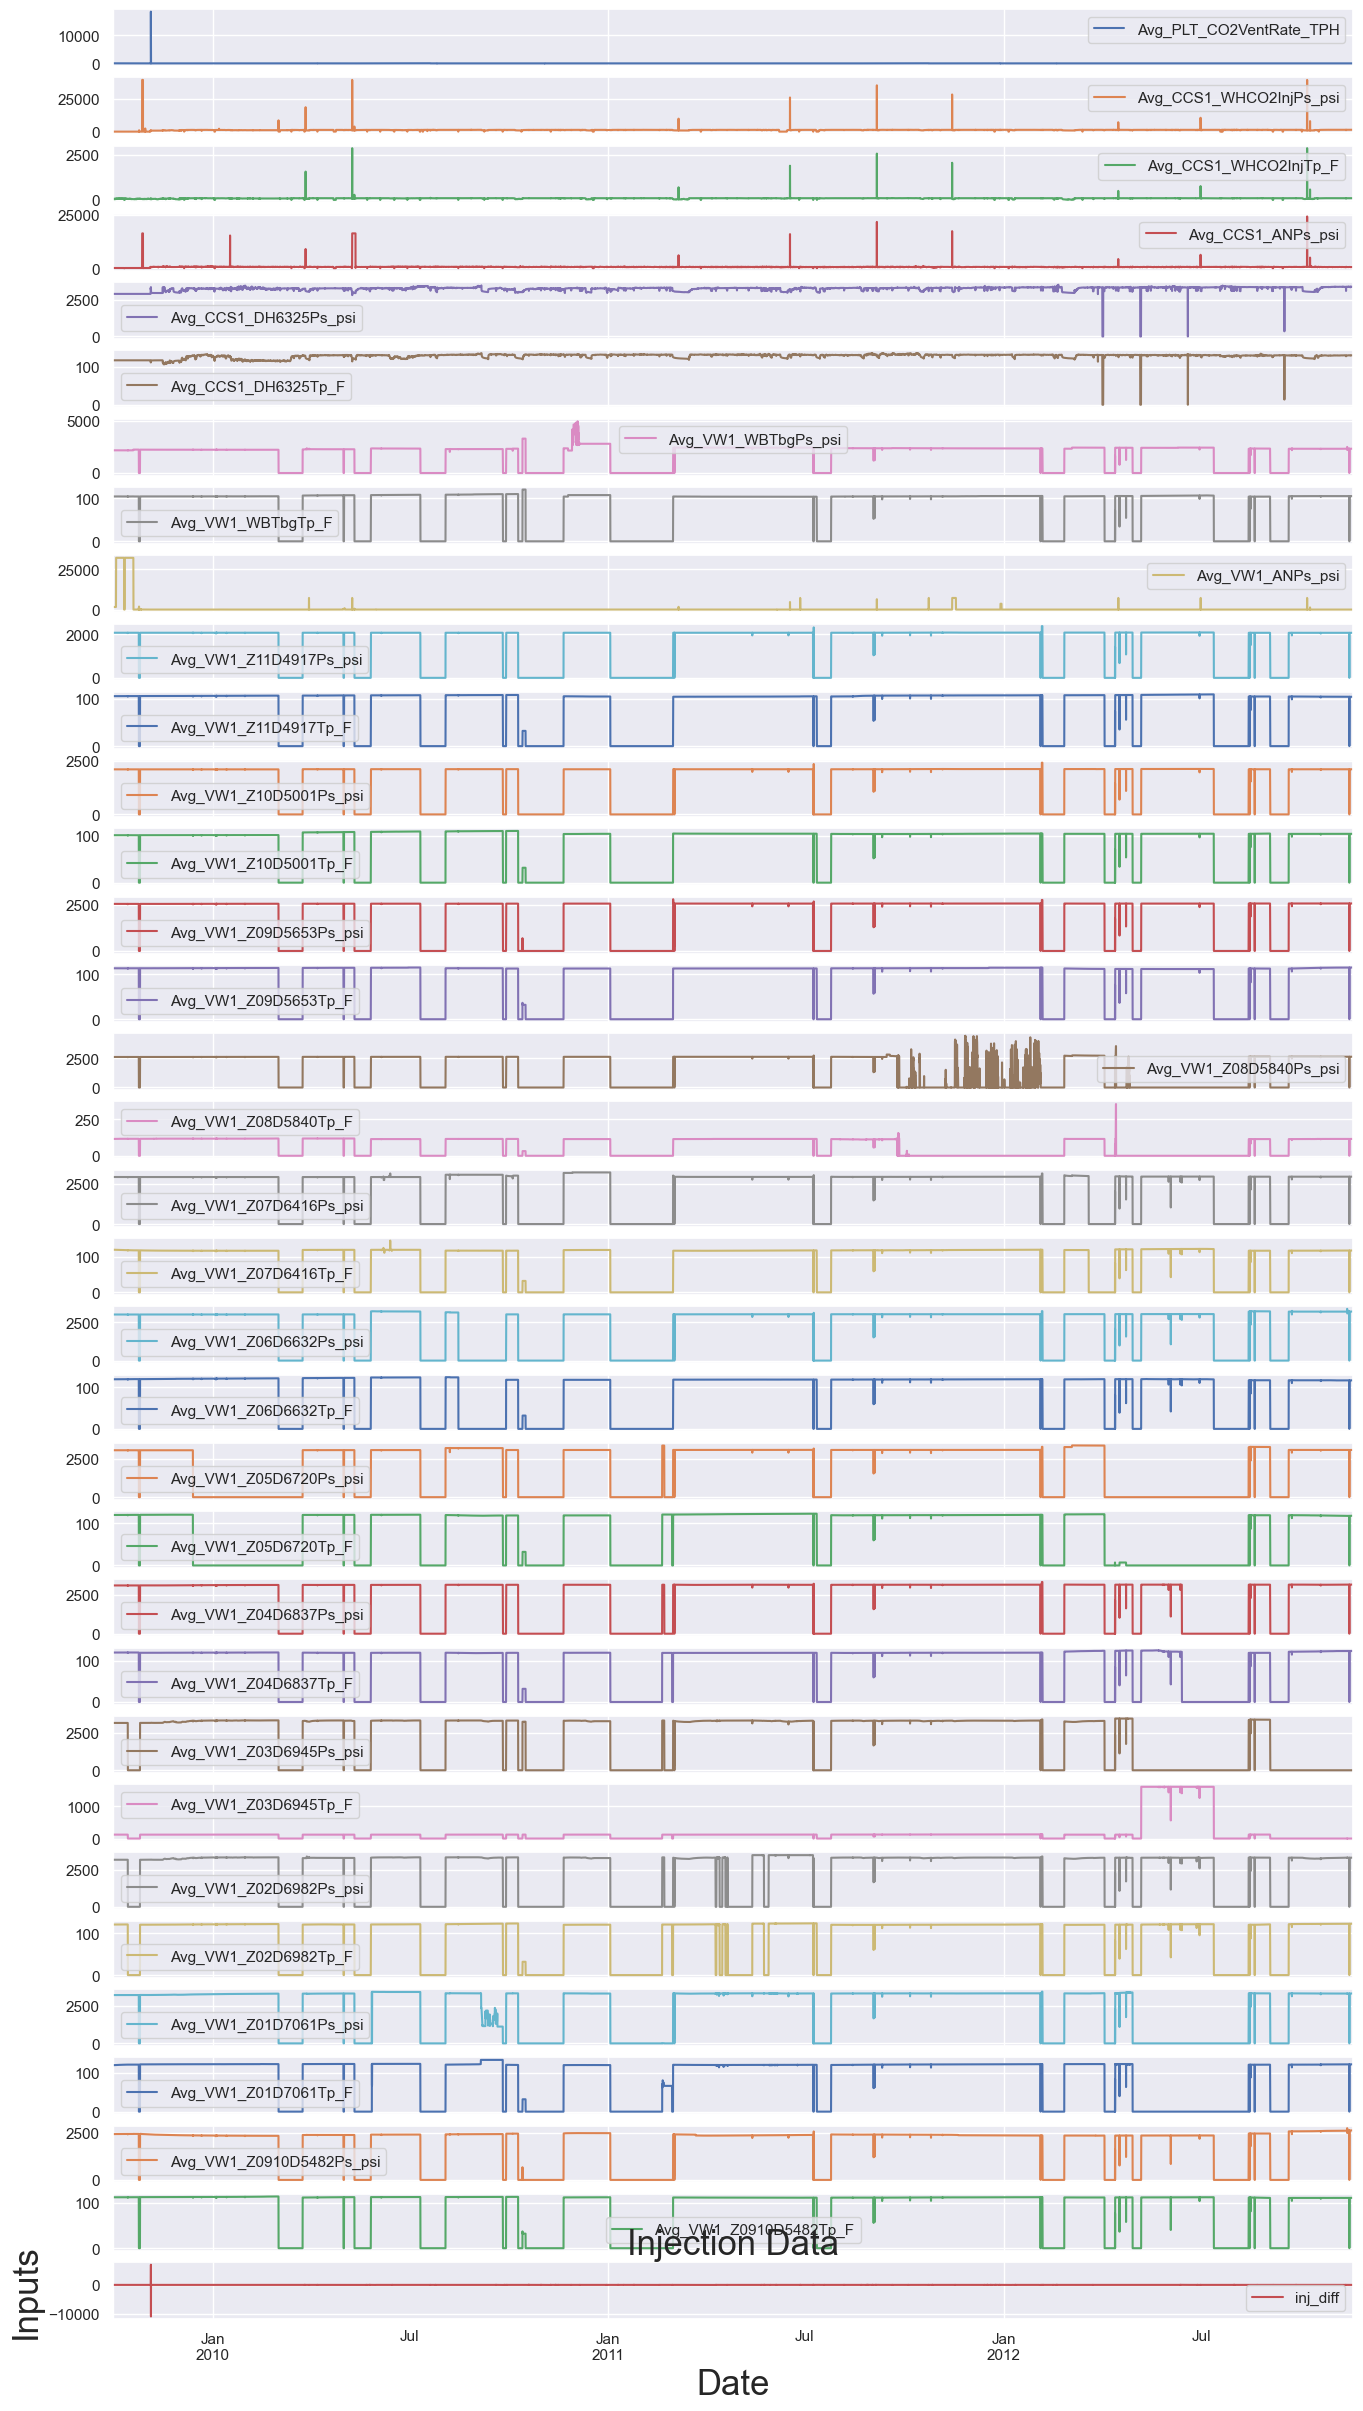

In [19]:
# sort by date
df3 = df3.sort_index()

# plot
df3.plot(figsize=(16, 30), subplots=True, sharex=True)
plt.title("Injection Data", size=fontsize)
plt.xlabel("Date", size=fontsize)
plt.ylabel("Inputs", size=fontsize)
plt.show()

In [20]:
df3.corr().style.background_gradient(cmap = "YlGnBu")

,Avg_PLT_CO2VentRate_TPH,Avg_CCS1_WHCO2InjPs_psi,Avg_CCS1_WHCO2InjTp_F,Avg_CCS1_ANPs_psi,Avg_CCS1_DH6325Ps_psi,Avg_CCS1_DH6325Tp_F,Avg_VW1_WBTbgPs_psi,Avg_VW1_WBTbgTp_F,Avg_VW1_ANPs_psi,Avg_VW1_Z11D4917Ps_psi,Avg_VW1_Z11D4917Tp_F,Avg_VW1_Z10D5001Ps_psi,Avg_VW1_Z10D5001Tp_F,Avg_VW1_Z09D5653Ps_psi,Avg_VW1_Z09D5653Tp_F,Avg_VW1_Z08D5840Ps_psi,Avg_VW1_Z08D5840Tp_F,Avg_VW1_Z07D6416Ps_psi,Avg_VW1_Z07D6416Tp_F,Avg_VW1_Z06D6632Ps_psi,Avg_VW1_Z06D6632Tp_F,Avg_VW1_Z05D6720Ps_psi,Avg_VW1_Z05D6720Tp_F,Avg_VW1_Z04D6837Ps_psi,Avg_VW1_Z04D6837Tp_F,Avg_VW1_Z03D6945Ps_psi,Avg_VW1_Z03D6945Tp_F,Avg_VW1_Z02D6982Ps_psi,Avg_VW1_Z02D6982Tp_F,Avg_VW1_Z01D7061Ps_psi,Avg_VW1_Z01D7061Tp_F,Avg_VW1_Z0910D5482Ps_psi,Avg_VW1_Z0910D5482Tp_F,inj_diff
Avg_PLT_CO2VentRate_TPH,1.000000,-0.001364,-0.004955,-0.001381,-0.005509,-0.022164,0.005692,0.007135,0.016188,0.007093,0.006990,0.007022,0.006281,0.006972,0.007194,0.010122,0.010824,0.007066,0.007345,0.007633,0.008106,0.010311,0.010627,0.007411,0.007463,0.005861,-0.002969,0.003924,0.004620,0.008151,0.008511,0.007345,0.007255,0.528037
Avg_CCS1_WHCO2InjPs_psi,-0.001364,1.000000,0.527558,0.531192,0.063780,0.068782,-0.000876,-0.004762,-0.100438,-0.003672,-0.004546,-0.003519,-0.003741,-0.003485,-0.005130,-0.025238,-0.029551,-0.005234,-0.006373,-0.004003,-0.006988,-0.004369,-0.005453,-0.008218,-0.008810,-0.004897,0.019764,0.013153,0.012658,-0.011794,-0.014192,-0.002877,-0.005448,0.000667
Avg_CCS1_WHCO2InjTp_F,-0.004955,0.527558,1.000000,0.339498,0.140601,0.140344,-0.024939,-0.030249,-0.029594,-0.030543,-0.030845,-0.030250,-0.028387,-0.030164,-0.031682,-0.055183,-0.060487,-0.031704,-0.031581,-0.033789,-0.037450,-0.033965,-0.033922,-0.037522,-0.037766,-0.039884,0.027791,-0.018309,-0.021096,-0.043363,-0.045724,-0.030112,-0.032416,0.000158
Avg_CCS1_ANPs_psi,-0.001381,0.531192,0.339498,1.000000,-0.066233,-0.038601,-0.007787,-0.004489,-0.048813,-0.004923,-0.005102,-0.004855,-0.003213,-0.004921,-0.004881,0.011621,0.013935,-0.002945,-0.002757,-0.004298,-0.002994,0.002915,0.001975,-0.003321,-0.005789,0.009734,-0.011867,0.009021,0.007837,0.002869,0.001407,-0.004882,-0.005299,-0.000036
Avg_CCS1_DH6325Ps_psi,-0.005509,0.063780,0.140601,-0.066233,1.000000,0.820485,-0.050103,-0.059286,-0.243123,-0.055646,-0.055436,-0.054994,-0.051434,-0.054823,-0.057385,-0.160931,-0.177985,-0.033067,-0.032410,-0.055187,-0.063403,-0.116406,-0.116821,-0.072602,-0.072154,-0.084053,0.101697,-0.016125,-0.021077,-0.097669,-0.109175,-0.057149,-0.058973,0.005210
Avg_CCS1_DH6325Tp_F,-0.022164,0.068782,0.140344,-0.038601,0.820485,1.000000,-0.034918,-0.060577,-0.185115,-0.064697,-0.062923,-0.063481,-0.051553,-0.063255,-0.065352,-0.175207,-0.195445,-0.036020,-0.037113,-0.090610,-0.097003,0.033398,0.039221,-0.071353,-0.068459,-0.051409,0.060483,-0.050955,-0.051949,-0.092949,-0.091320,-0.063363,-0.067591,-0.000507
Avg_VW1_WBTbgPs_psi,0.005692,-0.000876,-0.024939,-0.007787,-0.050103,-0.034918,1.000000,0.980769,0.045447,0.975284,0.971993,0.975351,0.972043,0.975518,0.971670,0.650443,0.617620,0.942768,0.936988,0.891747,0.887245,0.700420,0.674754,0.901847,0.878957,0.734334,0.269035,0.878830,0.854690,0.821000,0.813801,0.974732,0.972005,0.000071
Avg_VW1_WBTbgTp_F,0.007135,-0.004762,-0.030249,-0.004489,-0.059286,-0.060577,0.980769,1.000000,0.065583,0.983095,0.994692,0.983136,0.994691,0.983116,0.994323,0.662430,0.642785,0.949368,0.959886,0.886783,0.896374,0.695267,0.681319,0.911063,0.901719,0.734893,0.262664,0.888731,0.879212,0.828227,0.839624,0.981957,0.994449,-0.000024
Avg_VW1_ANPs_psi,0.016188,-0.100438,-0.029594,-0.048813,-0.243123,-0.185115,0.045447,0.065583,1.000000,0.069409,0.067283,0.068744,0.060073,0.068191,0.068966,0.091952,0.093281,0.069020,0.072667,0.072507,0.075678,0.093017,0.094674,0.070443,0.071706,0.002744,-0.030826,-0.018469,-0.014386,0.075530,0.077580,0.073481,0.069634,-0.000036
Avg_VW1_Z11D4917Ps_psi,0.007093,-0.003672,-0.030543,-0.004923,-0.055646,-0.064697,0.975284,0.983095,0.069409,1.000000,0.991631,0.999996,0.990645,0.999967,0.991690,0.670970,0.63380

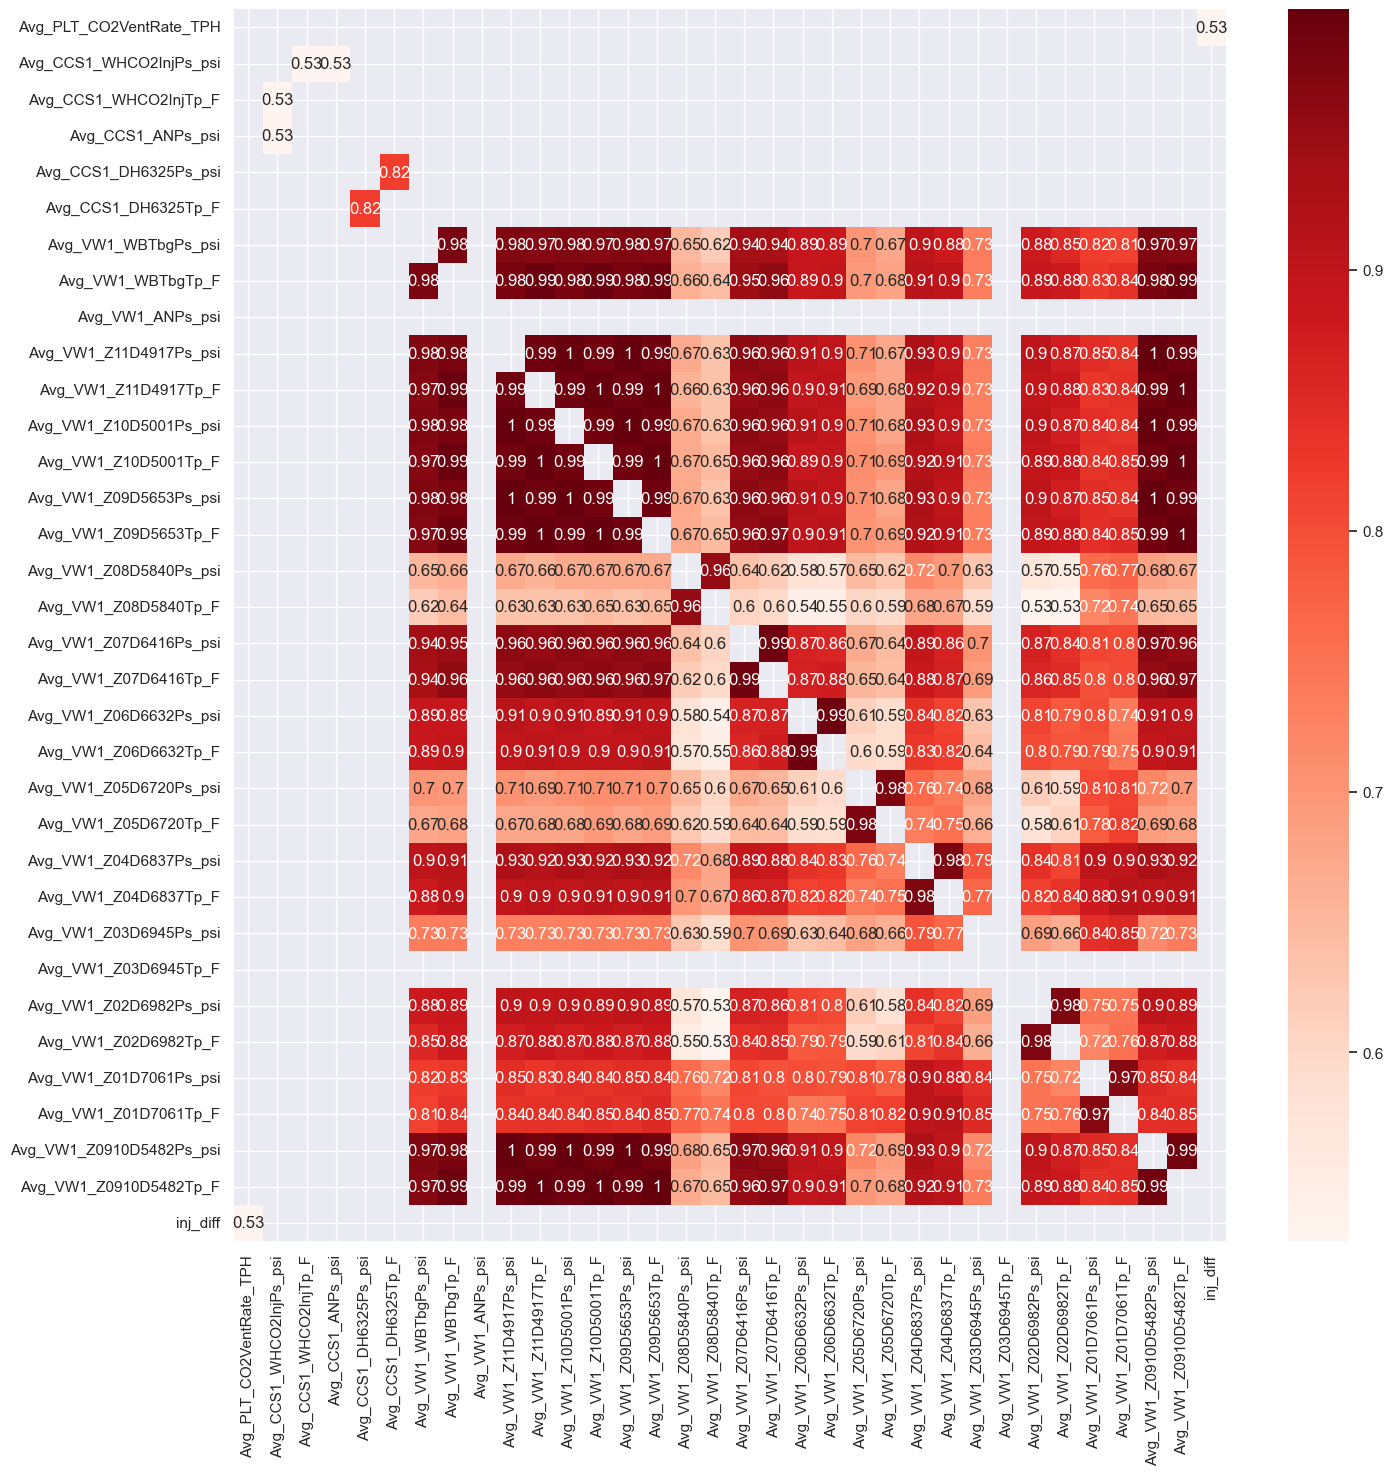

In [21]:
cor_matrix = df3.corr()

filteredDf = cor_matrix[((cor_matrix >= .5) | (cor_matrix <= -.5)) & (cor_matrix !=1.000)]
plt.figure(figsize=(16,16))
sns.heatmap(filteredDf, annot=True, cmap="Reds")
plt.savefig('matrix.jpeg')
plt.show()

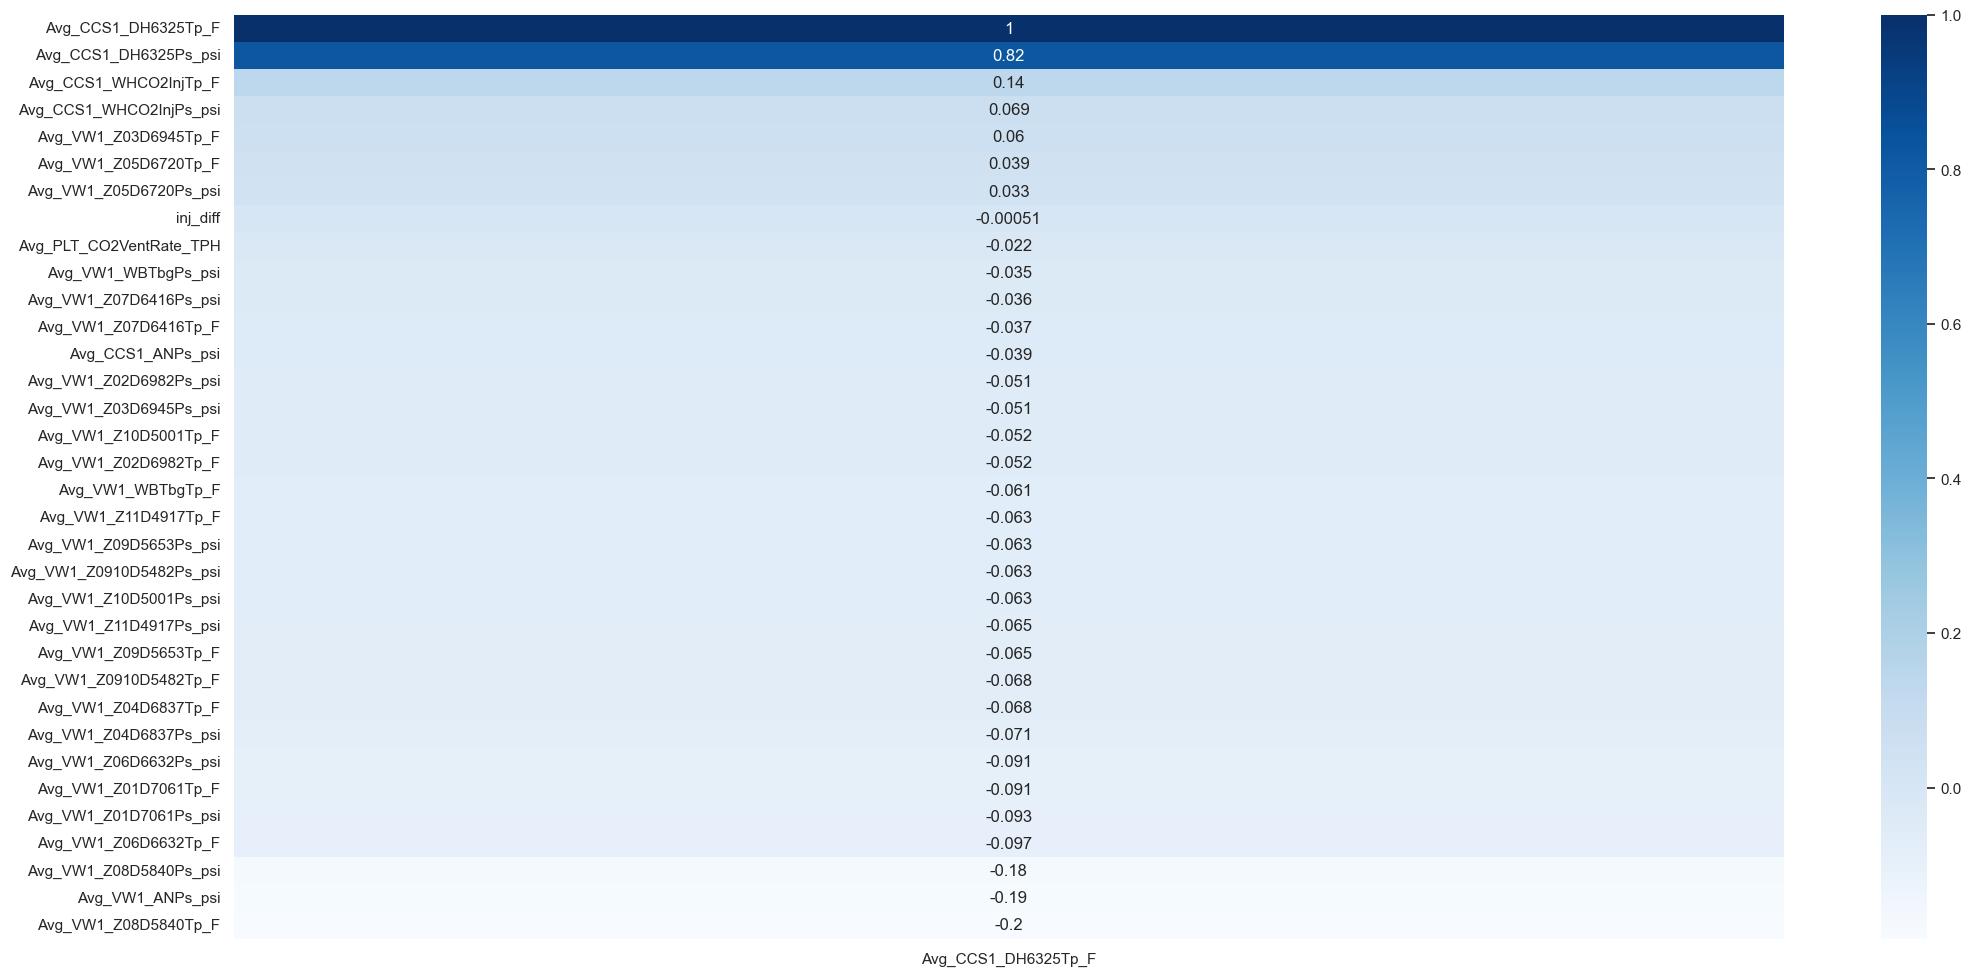

In [22]:
#Ranking the correlatable variables
cor_matrix = df3.corr()
cor_matrix[['Avg_CCS1_DH6325Tp_F']]

f, ax = plt.subplots(figsize=(25, 12))
sns.heatmap(cor_matrix[['Avg_CCS1_DH6325Tp_F']].sort_values(by=['Avg_CCS1_DH6325Tp_F'], 
                                                 ascending =False), annot=True, cmap="Blues")

plt.show()

In [23]:
drop_cols = [col for col in df3.columns if 'Tp_F' in col]
df4 = df3[df3.columns.drop(drop_cols)]

Feature = [
    'Avg_PLT_CO2VentRate_TPH', 
    'Avg_CCS1_WHCO2InjPs_psi', 
    #'Avg_CCS1_ANPs_psi',
    #'Avg_CCS1_DH6325Ps_psi', 
    #'Avg_VW1_WBTbgPs_psi', 
    #'Avg_VW1_ANPs_psi', 
    #'Avg_VW1_Z01D7061Ps_psi', 
    'inj_diff',
          ]

df5 = df4[Feature]
df5["Delta_Avg_CCS1_WHCO2InjPs_psi"]=df5["Avg_CCS1_WHCO2InjPs_psi"].diff().fillna(0)
df5["Delta_Avg_PLT_CO2VentRate_TPH"]=df5["Avg_PLT_CO2VentRate_TPH"].diff().fillna(0)
df5.drop(['Avg_CCS1_WHCO2InjPs_psi', 'Avg_PLT_CO2VentRate_TPH'], axis=1, inplace=True)

df_clean = df5.copy()
df_clean.ends()

,inj_diff,Delta_Avg_CCS1_WHCO2InjPs_psi,Delta_Avg_PLT_CO2VentRate_TPH
SampleTimeUTC,,,
2009-10-01 00:00:00,0.000000,0.000000,0.000000
2009-10-01 01:00:00,0.000000,-0.505859,0.000000
2009-10-01 02:00:00,0.000000,-0.059245,0.000000
2009-10-01 03:00:00,0.000000,-0.059245,0.000000
2009-10-01 04:00:00,0.000000,0.086589,0.000000
2012-11-18 03:00:00,-0.031250,0.590679,0.008333
2012-11-18 04:00:00,-0.091320,-0.665153,0.050000
2012-11-18 05:00:00,-0.137501,-0.387288,0.050000
2012-11-18 06:00:00,0.037290,-1.860119,-0.004132


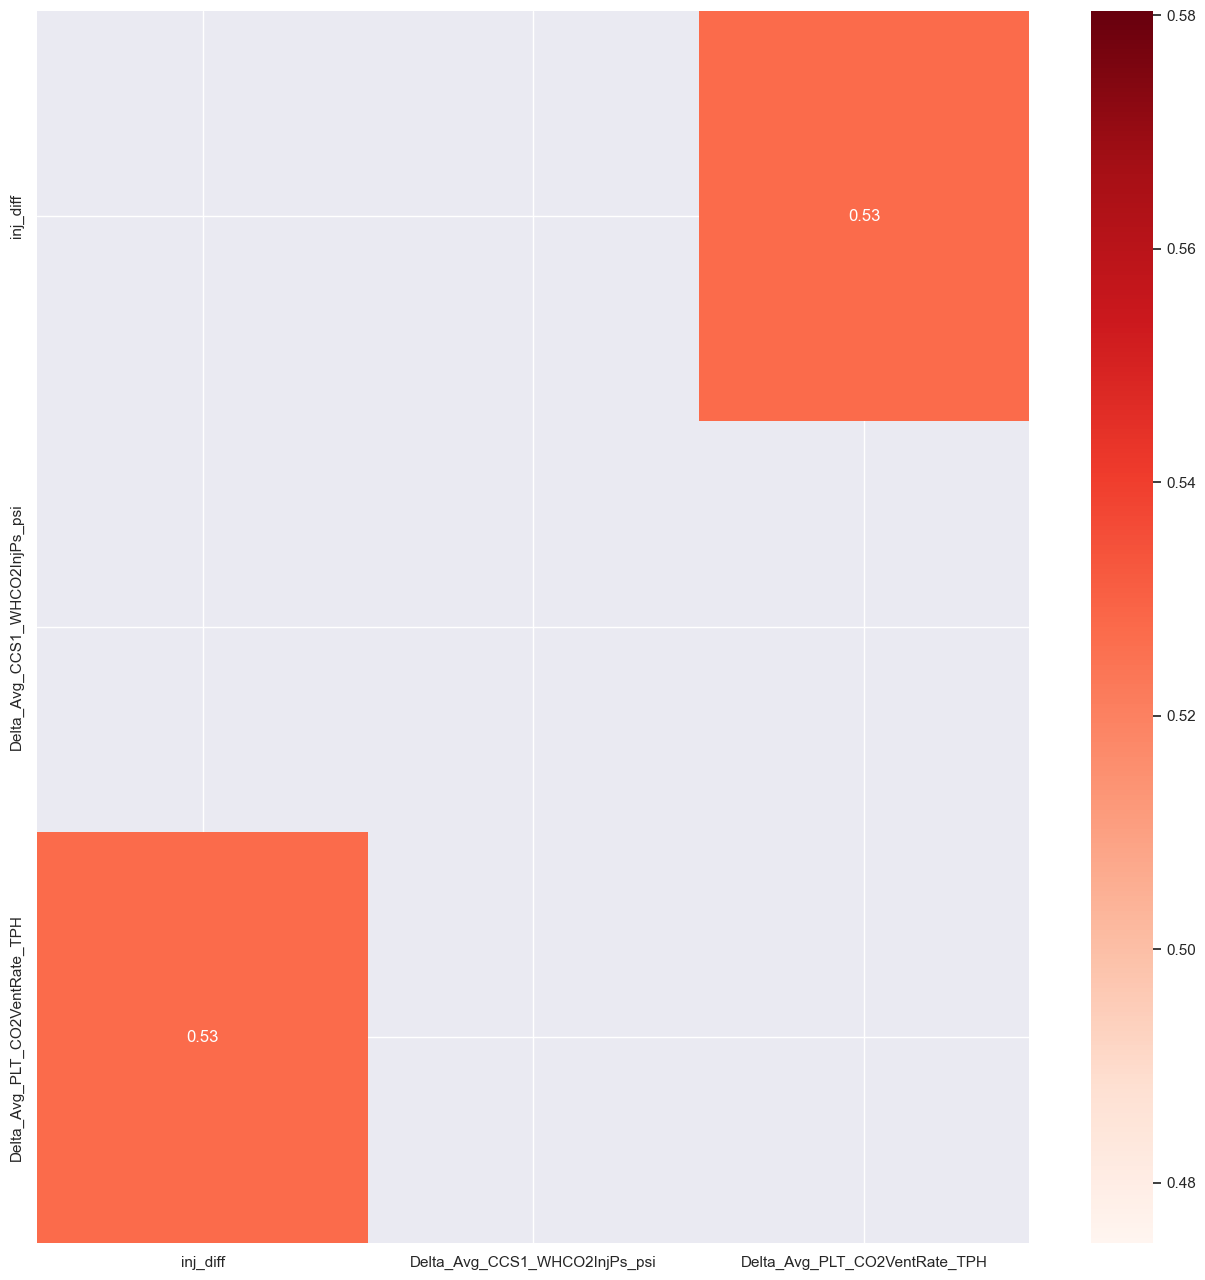

In [24]:
cor_matrix = df_clean.corr()

filteredDf = cor_matrix[((cor_matrix >= .5) | (cor_matrix <= -.5)) & (cor_matrix !=1.000)]
plt.figure(figsize=(16,16))
sns.heatmap(filteredDf, annot=True, cmap="Reds")
plt.savefig('matrix2.jpeg')
plt.show()

In [25]:
# to remove outliers
# Based on https://stackoverflow.com/questions/59489073/how-to-not-remove-but-handle-outliers-by-transforming-using-pandas
def cap_outliers(series, zscore_threshold=3.5, verbose=False):
    '''Caps outliers to closest existing value within threshold (Modified Z-score).'''
    median_val = series.median()
    mad_val = series.mad() # Median absolute deviation

    z_score = (series - median_val) / mad_val
    outliers = abs(z_score) > zscore_threshold

    series = series.copy()
    series.loc[z_score > zscore_threshold] = series.loc[~outliers].max()
    series.loc[z_score < -zscore_threshold] = series.loc[~outliers].min() 

    # For comparison purposes.
    if verbose:
            lbound = median_val - zscore_threshold * mad_val
            ubound = median_val + zscore_threshold * mad_val
            print('\n'.join(
                ['Capping outliers by the Modified Z-score method:',
                 f'   Z-score threshold: {zscore_threshold}',
                 f'   Lower bound: {lbound}',
                 f'   Upper bound: {ubound}\n']))

    return series

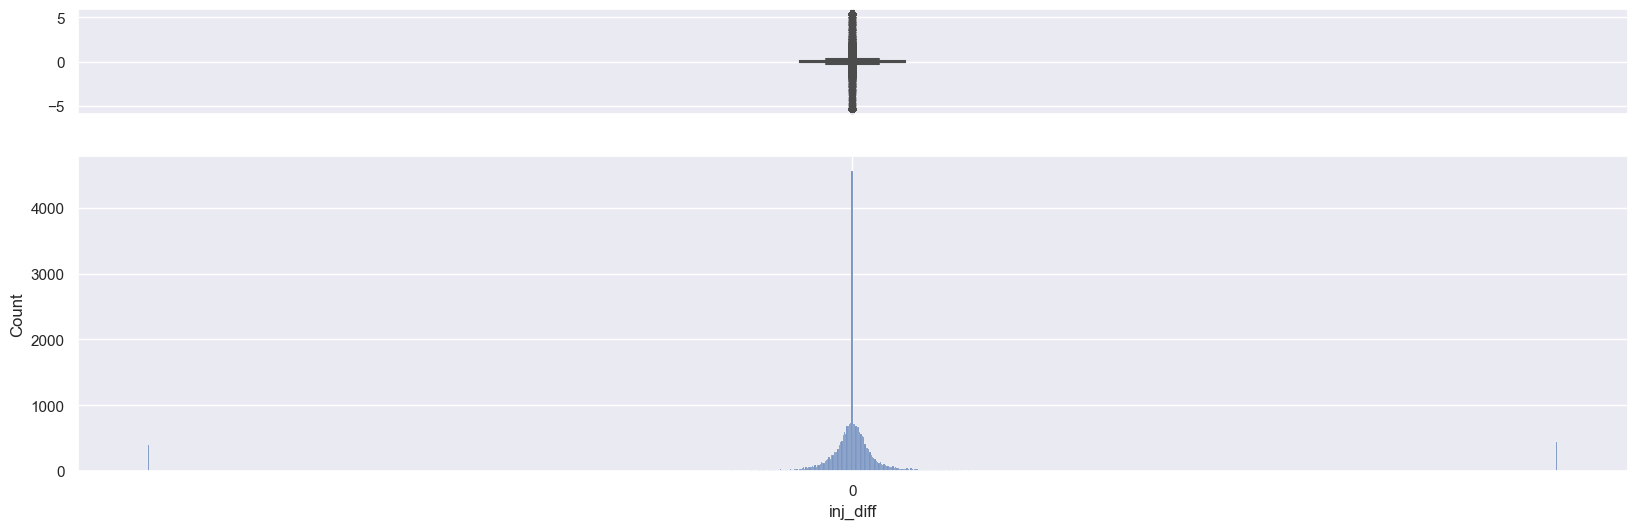

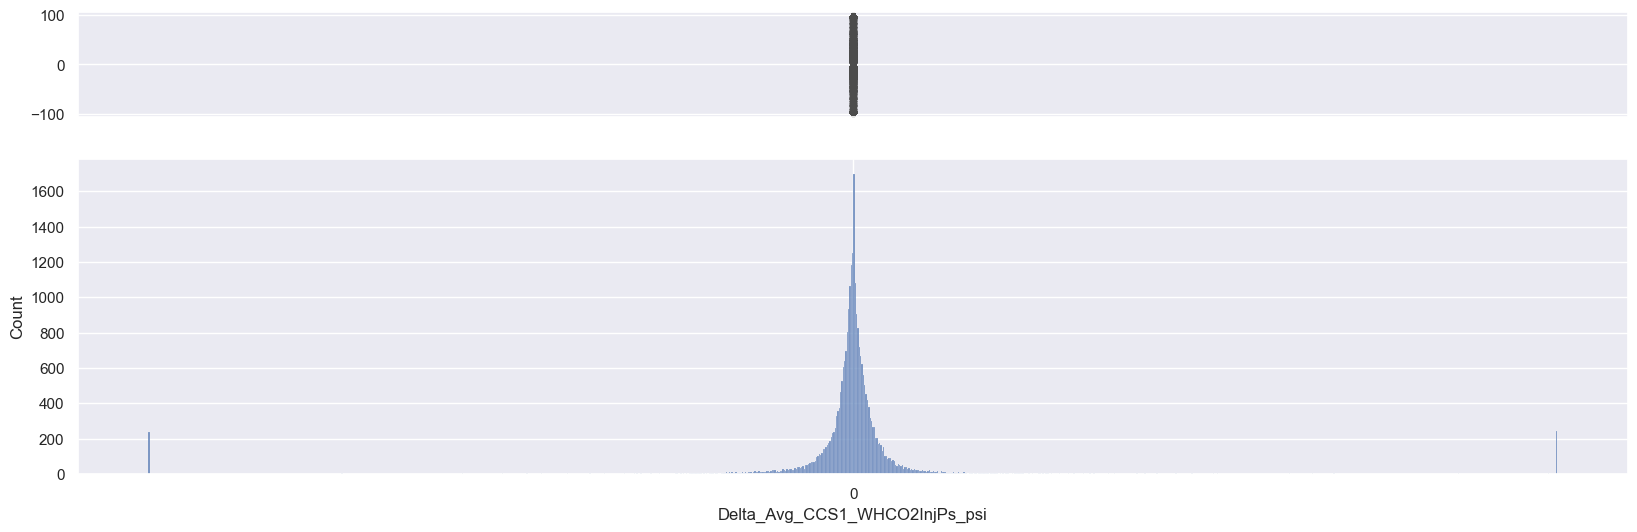

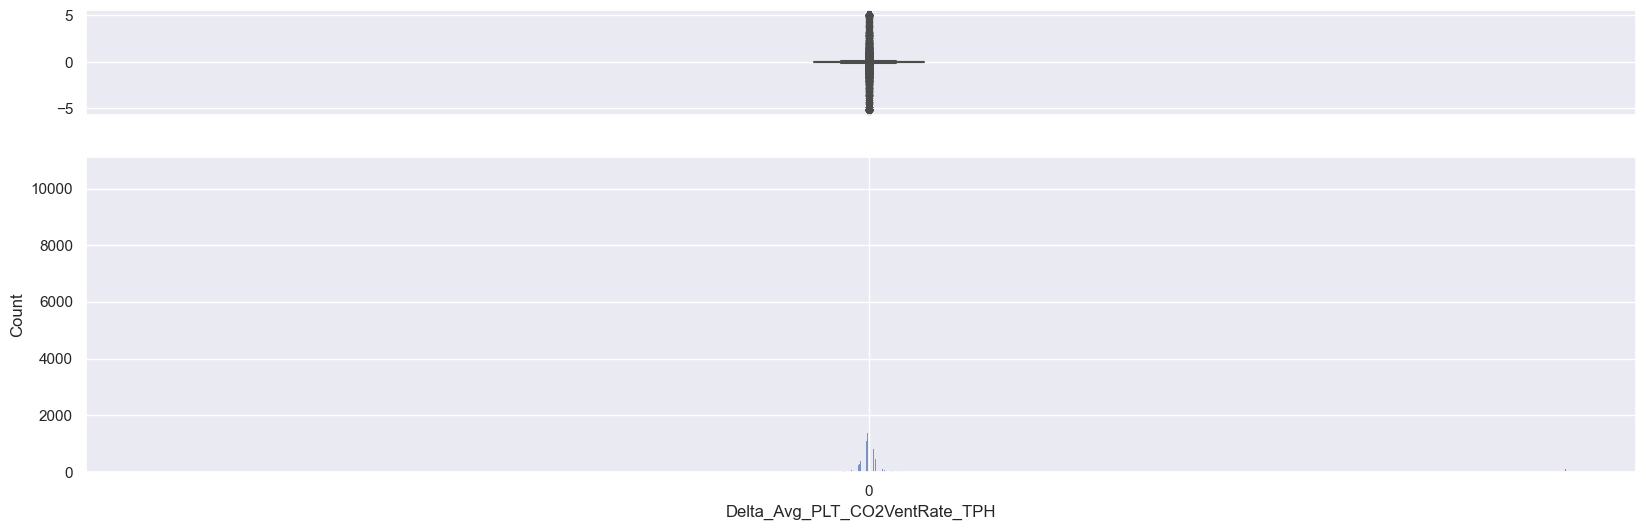

In [26]:
# Use apply because it will take each row/column, works on both user defined 
# or pandas defined function. 

df_clean = df_clean.apply(cap_outliers)

for i in df_clean.columns:
    creating_box_hist(str(i), df_clean)

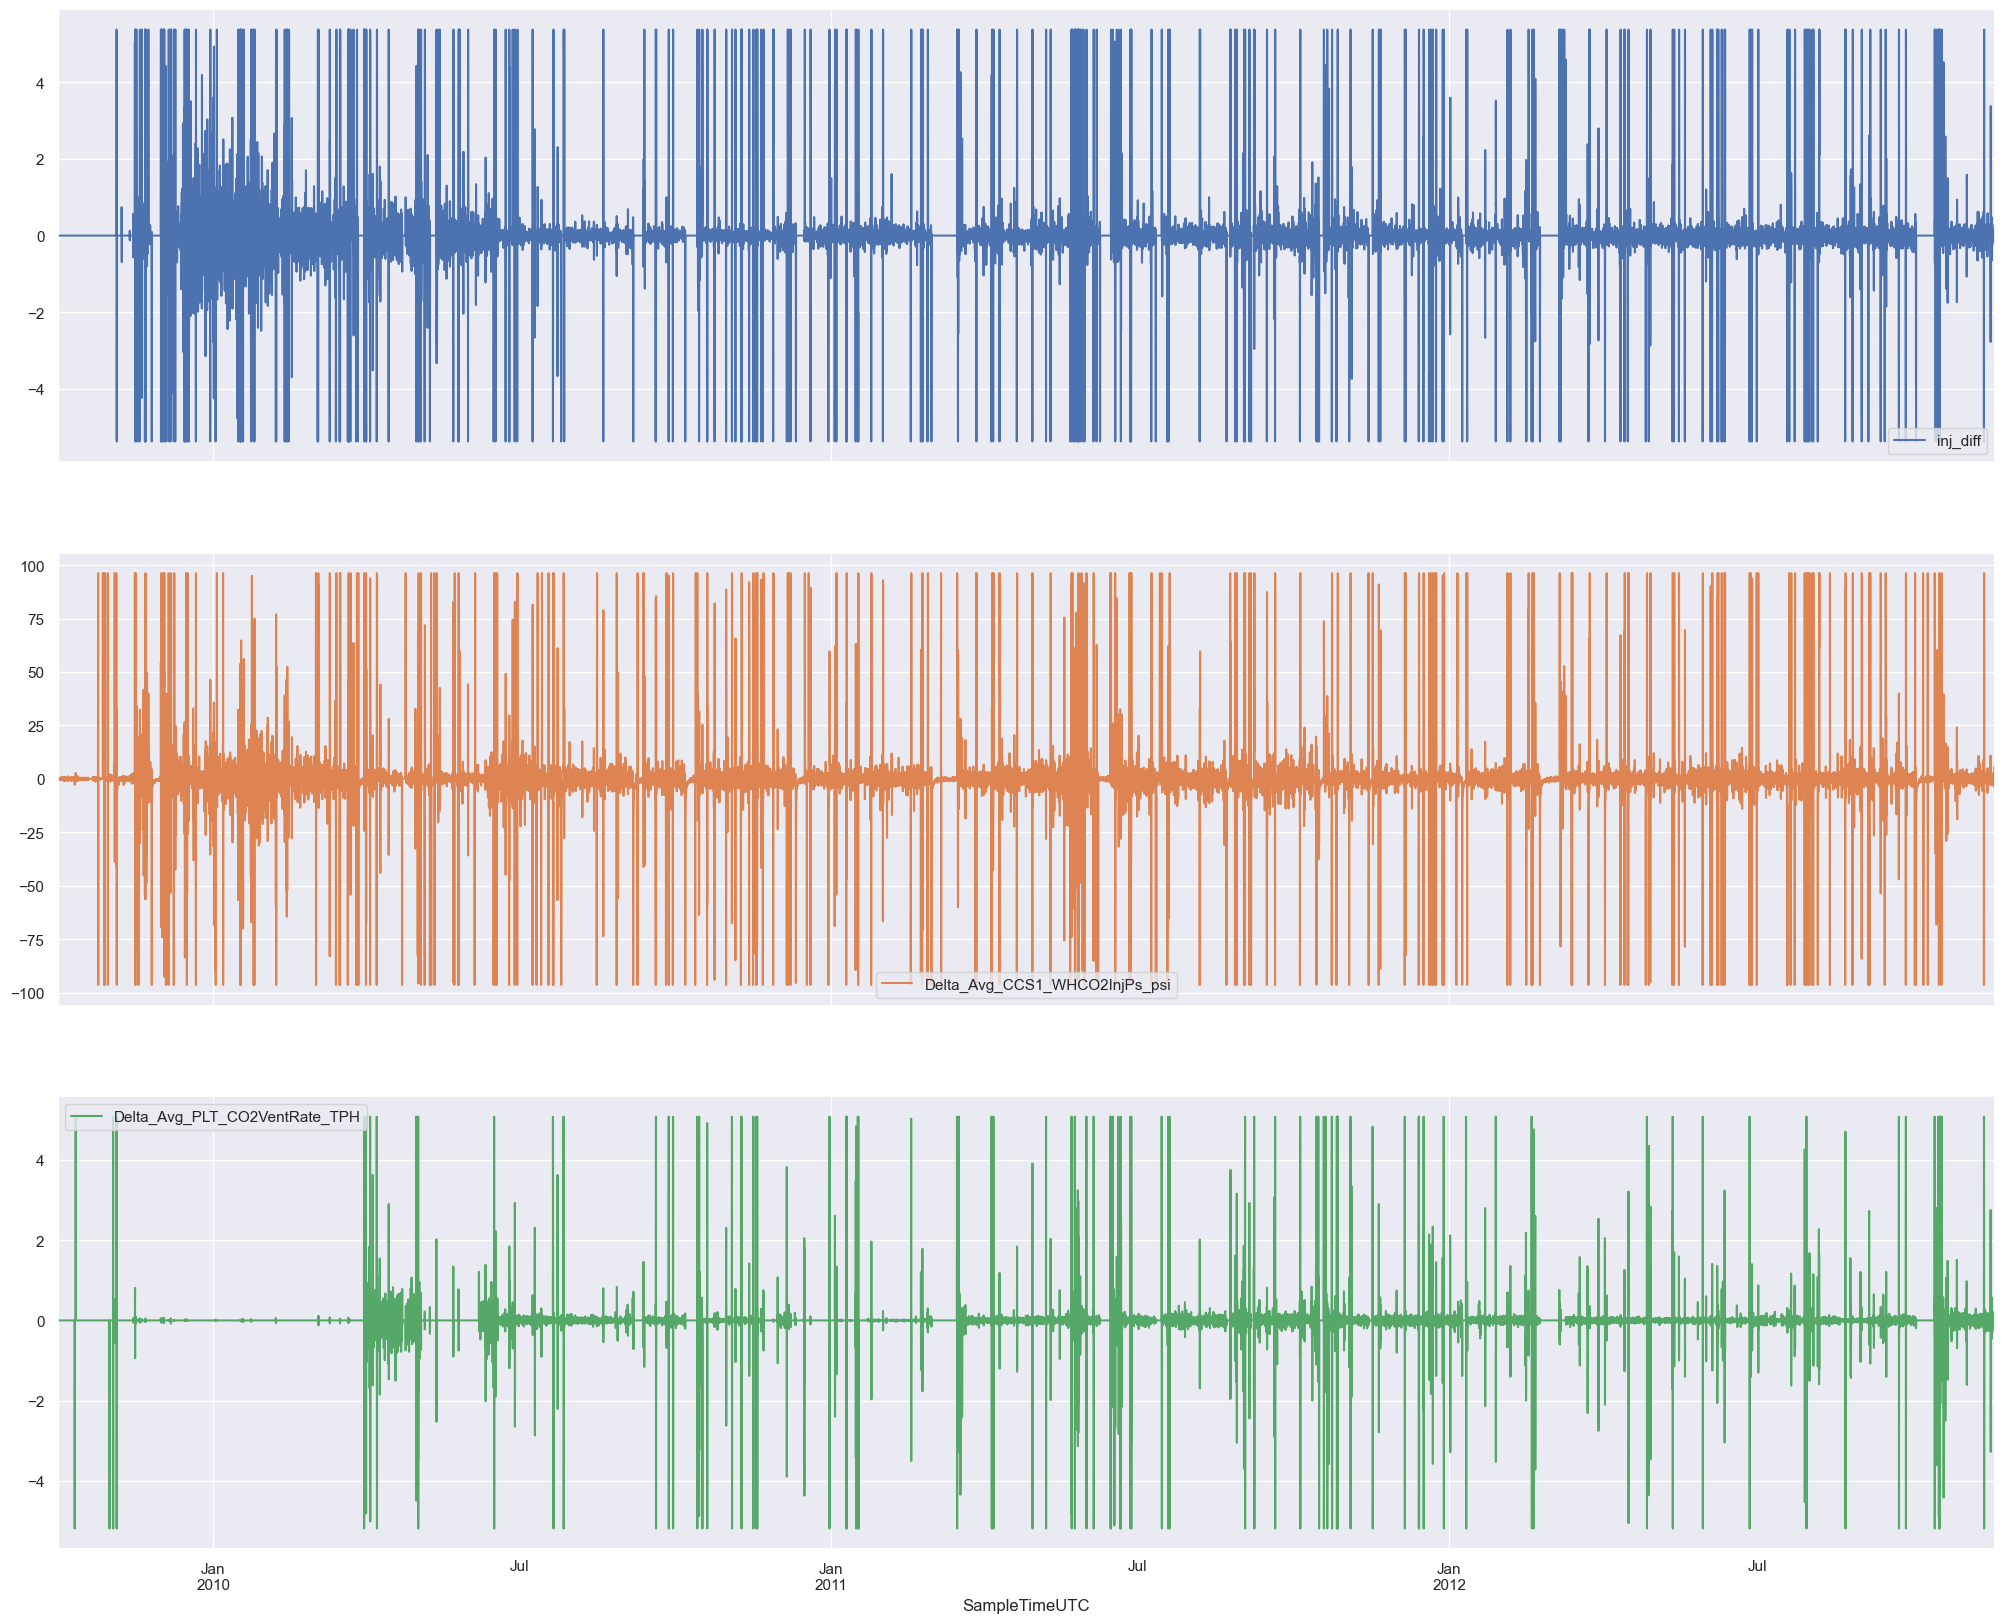

In [27]:
df_clean.plot(subplots=True, figsize=(25, 20))
plt.show()

In [28]:
base_filename = 'Cleaned_data'
csvs_sht = os.path.join(dir_name, base_filename + "." + filename_suffix)
df_clean.to_csv(csvs_sht, index = True, header = True)
print ("File exported:", base_filename + "." + filename_suffix)

File exported: Cleaned_data.csv


The data cleaning has focused on removing outliers and also removing high correlation values. As can be seen above, a lot of the data from the observation well is highly correlatable and not very useful. It makes sense as there are sensors located at different depths, but essentially measuring the same thing. Therefore, only 1 piece of that data should be retained. 

There are also "red herring" data like temperature which is directly correltable to pressure. Again, it will not be very useful. Also, annulus pressure is not very helpful in prediciting the injection delta.

Finally, we remove data that is outside the modified Z-score range (http://colingorrie.github.io/outlier-detection.html).

# Deployment of LSTM Model

LSTMs can be used to model univariate time series forecasting problems, where we have a single series of observations and a model is required to learn from the series of past observations to predict the next value in the sequence.

### References

1. https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
2. https://towardsdatascience.com/dropout-in-neural-networks-47a162d621d9
3. https://machinelearningmastery.com/stacked-long-short-term-memory-networks/
4. https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/
5. https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/
6. https://www.v7labs.com/blog/neural-networks-activation-functions

### Libraries

In [29]:
# Sklearn Liraries
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_absolute_error , mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

#Tensorflow Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense,LSTM,Activation

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from tensorflow.keras.layers import Dense,LSTM,Activation, Dropout, Bidirectional, TimeDistributed

# Nueral Networks are stocastic; setting random seeds ensures we get the same output each time
SEED = 42
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # TF 2.1
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(tf.__version__)

2.12.0


### Functions

In [30]:
# normalization to ensure data is on same scale
scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = StandardScaler()

def reshape_data(train_x, train_y, test_x, test_y):
    # convert to [rows, columns] structure
    x_train = train_x.reshape((train_x.shape[0], train_x.shape[1]))
    y_train = train_y.reshape((train_y.shape[0], 1))
    
    x_test = test_x.reshape((test_x.shape[0], test_x.shape[1]))
    y_test = test_y.reshape((test_y.shape[0], 1))

    # normalization features
    x_scaled = scaler.fit_transform(x_train)
    testx_scaled = scaler.transform(x_test)
    
    # y_scaled = scaler.fit_transform(y_train)
    # testy_scaled = scaler.transform(y_test)
    
    # Not transforming the x
    # x_scaled = x_train
    # testx_scaled = x_test
        
    # Not transforming the y
    y_scaled = y_train
    testy_scaled = y_test
       
    # horizontally stack columns
    dataset_stacked_train = np.hstack((x_scaled, y_scaled))
    dataset_stacked_test = np.hstack((testx_scaled, testy_scaled))
    
    print ("train dataset_stacked.shape" , dataset_stacked_train.shape) 
    print ("test dataset_stacked.shape" , dataset_stacked_test.shape)
    return dataset_stacked_train, dataset_stacked_test

The LSTM model will learn a function that maps a sequence of past observations as input to an output observation. As such, the sequence of observations must be transformed into multiple examples from which the LSTM can learn.

In [31]:
# split sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out=1):
    
    """
    create lagged value sequence for time series data
    
    Parameters:
    ============
    
    Sequence:
    =========
    The dataset contain x and y values. x can be single column or mutliple columns. Y will be last column.
    
    n_steps_in:
    ===========
    The preferrable window size for past data (or lagged values). 
    
    n_steps_out:
    ============
    The default is 1.
    
    output:
    =======
    x: The independent variable array
    y: The y(dependent variable)
    
    """
    X, y = list(), list()
    for i in range(len(sequences)):
    # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        #seq_x, seq_y = sequences[i:end_ix, :-1], sequences[i:end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    #print(seq_x)
    #print(seq_y)
    return np.array(X), np.array(y)

In [32]:
#loss plot to identify optimal model parameters from training
def loss_plot(history):
    
    plt.rcParams['figure.figsize'] = [24, 12]
    plt.plot(history.history['mse'])
    plt.plot(history.history['val_mse'])
    plt.title('model accuracy')
    plt.ylabel('Mean Square Error')
    plt.xlabel('epoch')
    plt.legend(['train MSE', 'val MSE'], loc='upper left')
    plt.show()
    
    plt.rcParams['figure.figsize'] = [24, 12]
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train loss', 'val loss'], loc='upper left')
    plt.show()

In [33]:
# To evaluate how well model predictions are doing
def evaluate_prediction(predictions, actual):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    r2 = r2_score(actual, predictions)
    print('Mean Square Error: {:.2f}'.format(mse))
    print('Mean Absolute Error: {:.2f}'.format(mae))
    print('Root Mean Square Error: {:.2f}'.format(rmse))
    print('R-Square: {:.2f}'.format(r2))
    print('')
    print('')
    
    list_df = [mse, rmse, mae, r2]
    df = pd.DataFrame(list_df, index=["MSE", "RMSE", "MAE", "R^2"])
    
    return df

#### The below function provides general LSTM model structure. 

In [34]:
# To Note:
# 1. n-neurons: Using 50 neurons, which can increased or decreased to check if it affects model results.
# 2. lr = Learning rate: Very important parameter; smaller values decrease model overfitting but increase computation time
# 3. optimizer = Adam: Note that we have to use the .legacy as new version of tf has some conflict
# 4. Dropout: By dropping out the nodes (input and hidden layer) in a neural network, all the forward and backwards
#    connections with a dropped node are temporarily removed, thus creating a new network architecture out of the 
#    parent network. The nodes are dropped by a dropout probability of p. It is applied to reduce overfitting
# 5. Stacked LSTM: An LSTM layer provides a sequence output rather than a single value output to the LSTM layer. 
#    Specifically, one output per input time step (creating a 3D data set), rather than one output time step for all 
#    input time steps (i.e. 1 single value)

# The selected model is a n-layer STACKED LSTM. This can also be increased by adding a new LSTM layer

def LSTM_model(opt, n_steps_in, n_features, n_steps_out, neurons, dropout, activation):
    
    """
    Parameters:
    ============
    
    opt:
    ====
    The learning rate for the model. default is 0.1
    
    n_steps_in:
    ===========
    The window size for past data(or lagged values), called samples.
    
    n_features:
    ============
    How many independent variables are used. 

    n_steps_out:
    =============
    The output size, which is 1 in this case
    
    output:
    =======
    compiled model
    
    """
    # define model
    model = Sequential()
    
    # add LSTM layer with tanh activation. return_sequences=True is used so we can feed another 
    # LSTM layer to model. default is false.
    model.add(LSTM(neurons, activation=activation, return_sequences=True, input_shape=(n_steps_in, n_features)))
    model.add(Dropout(dropout))
    # add second LSTM layer with tanh activation. return_sequences=True is used so we can feed another 
    # LSTM layer to model. default is false.
    #model.add(LSTM(neurons, activation=activation, return_sequences=True, input_shape=(n_steps_in, n_features)))
    #model.add(Dropout(dropout))
    # third layer of LSTM with tanh activation. Now return sequence is False, as there will be no other layer
    # except output layer.
    model.add(LSTM(neurons, activation=activation))
    model.add(Dropout(dropout))
    
    # final layer with output
    model.add(Dense(n_steps_out))
    
    # activation function of output layer
    model.add(Activation('tanh'))
    
    # compile model with loss funtion, optimizer and metrics
    model.compile(loss='mse' , optimizer=opt , metrics=['mse'])
    
    return model

In [35]:
data = df_clean.copy()
data.index

DatetimeIndex(['2009-10-01 00:00:00', '2009-10-01 01:00:00',
               '2009-10-01 02:00:00', '2009-10-01 03:00:00',
               '2009-10-01 04:00:00', '2009-10-01 05:00:00',
               '2009-10-01 06:00:00', '2009-10-01 07:00:00',
               '2009-10-01 08:00:00', '2009-10-01 09:00:00',
               ...
               '2012-11-17 22:00:00', '2012-11-17 23:00:00',
               '2012-11-18 00:00:00', '2012-11-18 01:00:00',
               '2012-11-18 02:00:00', '2012-11-18 03:00:00',
               '2012-11-18 04:00:00', '2012-11-18 05:00:00',
               '2012-11-18 06:00:00', '2012-11-18 07:00:00'],
              dtype='datetime64[ns]', name='SampleTimeUTC', length=27464, freq='H')

In [36]:
# Create numpy array for further analysis
# choose a number of time steps - change this accordingly
n_steps_in = 50 # Smaller the value, more accurate, slower. Tested 30, 50, 100, with 100 being the worst, and 30 as best
n_steps_out = 1

train = data[:("2011")]
test = data[("2012"):]
#print("Test data Before Normalisation:", test[-5:])

x_train, y_train = train.drop("inj_diff", axis=1).values, train["inj_diff"].values
x_test, y_test = test.drop("inj_diff", axis=1).values, test["inj_diff"].values
#print ("x_train.shape" , x_train.shape) 
#print ("y_train.shape" , y_train.shape) 

train_data, test_data = reshape_data(x_train, y_train, x_test, y_test)
#print("Test data After Normalisation:", test_data[-5:])

# covert into input/output
X, y = split_sequences(train_data, n_steps_in, n_steps_out)
x_test, y_test = split_sequences(test_data, n_steps_in, n_steps_out)
print ("X.shape" , X.shape) 
print ("y.shape" , y.shape)
#print ("x_test.shape" , x_test.shape) 
#print ("y_test.shape" , y_test.shape)
#print("X Test data After Split Sequence:", x_test[-5:])
#print("Y Test data After Split Sequence:", y_test[-5:])

n_features = X.shape[2]

train dataset_stacked.shape (19728, 3)
test dataset_stacked.shape (7736, 3)
X.shape (19679, 50, 2)
y.shape (19679, 1)


In [37]:
# Reshape x_test into a 2D array with shape (n_samples, n_features)
n_samples = x_test.shape[0] * x_test.shape[1] 
n_features = x_test.shape[2]
x_test_2d = x_test.reshape(n_samples, n_features)

# Inverse transform the 2D array
x_test_input = scaler.inverse_transform(x_test_2d)
#x_test_input = x_test_2d
print("X Test data After Inverse Normalisation:", x_test_input[-5:])

#y_test_input = scaler.inverse_transform(y_test)
y_test_input = y_test
print("Y Test data After Inverse Normalisation:", y_test_input[-5:])

X Test data After Inverse Normalisation: [[ 0.590679    0.00833333]
 [-0.665153    0.05      ]
 [-0.387288    0.05      ]
 [-1.860119   -0.00413165]
 [ 0.415611    0.11246499]]
Y Test data After Inverse Normalisation: [[-0.03124975]
 [-0.09131978]
 [-0.13750102]
 [ 0.03729034]
 [-0.0803453 ]]


# The following are input parameters that can be tweaked for nicer graphs if needed
# 1. n_splits - use larger values, which increases run time
# 2. lr - use smaller values which increases run time
# 3. epochs - use larger values which increases run time

data.index.name = "Time"
dd = data[(n_steps_in-1):]
d = dd.reset_index()

# split time series data in K-folds
# Tested 5 K-folds. Using n_splits=2 for speed.
tscv = TimeSeriesSplit(max_train_size=None, n_splits=10)

# Learning rate: Very important parameter; smaller values decrease model overfitting but increase computation time
# optimizer = Adam: Note that we have to use the .legacy as new version of tf has some conflict
# For lr, tested 0.001, but it takes a while to run. Using default of 0.1 for now
lr = 0.001

# Use 50 for ease of coding for now, but have tested 100 and 10. Epoch should be >100 for best fit
epochs = 100

# Use 20 as default. Can be increased at cost of time
neurons = 100

# Vary to test the goodness of fit
dropout = 0.1

# Other fucntions to consider
# https://www.v7labs.com/blog/neural-networks-activation-functions
activation = 'tanh'
#activation = 'relu'

opt = tf.keras.optimizers.legacy.Adam(learning_rate=lr)

val_pred = []

for train_index, test_index in tscv.split(X):
    
    # show date of train data: only for information
    print("Train Dates", d[d.index.isin(train_index)].Time[0],
          d[d.index.isin(train_index)].Time.iloc[-1])
    
    # show date of test data: only for information
    print("Test Dates", d[d.index.isin(test_index)].Time.iloc[0],
          d[d.index.isin(test_index)].Time.iloc[-1])
    
    # split data based on train and test index: X variable
    X_train, X_test = X[train_index], X[test_index]

    # split data based on train and test index: y variable
    y_train, y_test = y[train_index], y[test_index]   
    
    # caclulate steps based on legth of data and window size
    steps_per_epoch = len(X_train)//n_steps_in
    # start LSTM model
    model = LSTM_model(opt, n_steps_in, n_features, n_steps_out, neurons, dropout, activation)
    
    # In time series data shuffle will be false as order is important.
    hist = model.fit(X_train , y_train , epochs=epochs, steps_per_epoch=steps_per_epoch,
                    verbose=1 , validation_split=0.1, shuffle=False,
                        callbacks=[EarlyStopping('val_loss', mode='min', patience=20)])
    
    # plot Mean absolute error
    loss_plot(hist)
    
    # make predictions of test data length
    lstm_pr = model.predict(X_test)
    
    # reverse back to original scale
    pred = scaler.inverse_transform(lstm_pr)
    
    # create dataframe of predictions
    lstm1_predictions = pd.DataFrame(pred.reshape(pred.shape[1]*pred.shape[0]))

    # reverse back test values and create dataframe
    y_test = scaler.inverse_transform(y_test)
    y_test = pd.DataFrame(y_test.reshape(y_test.shape[1]*y_test.shape[0]))
    
    # New dataframe to save predictions and test data.
    results = pd.DataFrame()
    results["test"] = y_test
    results["LSTM_Predictions"] =lstm1_predictions
    
    # save each fold predictions in list outside of loop
    val_pred.append(results)
    
    # evaluate predictions accuracy
    evaluate_prediction(results["LSTM_Predictions"], results["test"])
    #print(df_error)
    # create index of each folder
    results["Date"] = pd.Series(d[d.index.isin(test_index)].Time.tolist())
    results.set_index("Date", inplace=True)
    
    # plot the predicions of each fold.
    results.plot(figsize=(20,7))
    plt.title('Model Accuracy')
    plt.ylabel('CO2 Injection')
    plt.xlabel('Date')
    plt.show()

    del model

all_pred = pd.concat(val_pred, axis=0)
plt.rcParams['figure.figsize'] = [24, 12]
all_pred.plot()
plt.ylabel("Delta")
plt.xlabel("Date")
plt.title("Predictions with LSTM")
plt.show()

Based on the K-fold cross-validation, we are getting reasonable fits. Therefore, the LSTM archtecture above will be deployed to the entire data set now

### Testing on the entire dataset. 
##### Variables for sensitivity to be tested 
1. Size of n_steps_in
2. Learning rate (lr)
3. Number of epochs
4. Size of steps_per_epoch
5. Number of neurons
6. Dropout size
7. Type of activation function

In [38]:
n_steps_in = 30
lr = 0.001 #This value must be kept low
epochs = 200
neurons = 50
dropout = 0.2
activation = 'tanh'

opt = tf.keras.optimizers.legacy.Adam(learning_rate=lr)

train = data[:("2012")]
test = data[("2012"):]

x_train, y_train = train.drop("inj_diff", axis=1).values, train["inj_diff"].values
x_test, y_test = test.drop("inj_diff", axis=1).values, test["inj_diff"].values

train_data, test_data = reshape_data(x_train, y_train, x_test, y_test)

# covert into input/output
X, y = split_sequences(train_data, n_steps_in, n_steps_out)
x_test, y_test = split_sequences(test_data, n_steps_in, n_steps_out)
print ("X.shape" , X.shape) 
print ("y.shape" , y.shape)

n_features = X.shape[2]

# caclulate steps based on legth of data and window size
steps_per_epoch = len(X)//n_steps_in
model = LSTM_model(opt, n_steps_in, n_features, n_steps_out, neurons, dropout, activation)
History =  model.fit(X, y, epochs=epochs, steps_per_epoch=steps_per_epoch,
                    verbose=1 , validation_split=0.2, shuffle=False,
                        callbacks=[EarlyStopping('val_loss', mode='min', patience=20)])

train dataset_stacked.shape (27464, 3)
test dataset_stacked.shape (7736, 3)
X.shape (27435, 30, 2)
y.shape (27435, 1)
Epoch 1/200
914/914 [==============================] - 17s 15ms/step - loss: 1.0297 - mse: 1.0297 - val_loss: 0.7873 - val_mse: 0.7873
Epoch 2/200
914/914 [==============================] - 13s 14ms/step - loss: 0.9634 - mse: 0.9634 - val_loss: 0.7086 - val_mse: 0.7086
Epoch 3/200
914/914 [==============================] - 13s 15ms/step - loss: 0.9145 - mse: 0.9145 - val_loss: 0.6940 - val_mse: 0.6940
Epoch 4/200
914/914 [==============================] - 13s 15ms/step - loss: 0.8867 - mse: 0.8867 - val_loss: 0.6944 - val_mse: 0.6944
Epoch 5/200
914/914 [==============================] - 13s 15ms/step - loss: 0.9030 - mse: 0.9030 - val_loss: 0.6898 - val_mse: 0.6898
Epoch 6/200
914/914 [==============================] - 13s 15ms/step - loss: 0.8745 - mse: 0.8745 - val_loss: 0.6892 - val_mse: 0.6892
Epoch 7/200
914/914 [==============================] - 13s 14ms/step - l

914/914 [==============================] - 13s 14ms/step - loss: 0.7933 - mse: 0.7933 - val_loss: 0.6650 - val_mse: 0.6650
Epoch 61/200
914/914 [==============================] - 13s 14ms/step - loss: 0.7718 - mse: 0.7718 - val_loss: 0.6591 - val_mse: 0.6591
Epoch 62/200
914/914 [==============================] - 13s 14ms/step - loss: 0.7730 - mse: 0.7730 - val_loss: 0.6616 - val_mse: 0.6616
Epoch 63/200
914/914 [==============================] - 13s 14ms/step - loss: 0.7712 - mse: 0.7712 - val_loss: 0.6614 - val_mse: 0.6614
Epoch 64/200
914/914 [==============================] - 13s 14ms/step - loss: 0.7725 - mse: 0.7725 - val_loss: 0.6636 - val_mse: 0.6636
Epoch 65/200
914/914 [==============================] - 13s 14ms/step - loss: 0.7923 - mse: 0.7923 - val_loss: 0.6632 - val_mse: 0.6632
Epoch 66/200
914/914 [==============================] - 13s 14ms/step - loss: 0.7741 - mse: 0.7741 - val_loss: 0.6690 - val_mse: 0.6690
Epoch 67/200
914/914 [==============================] - 13s 1

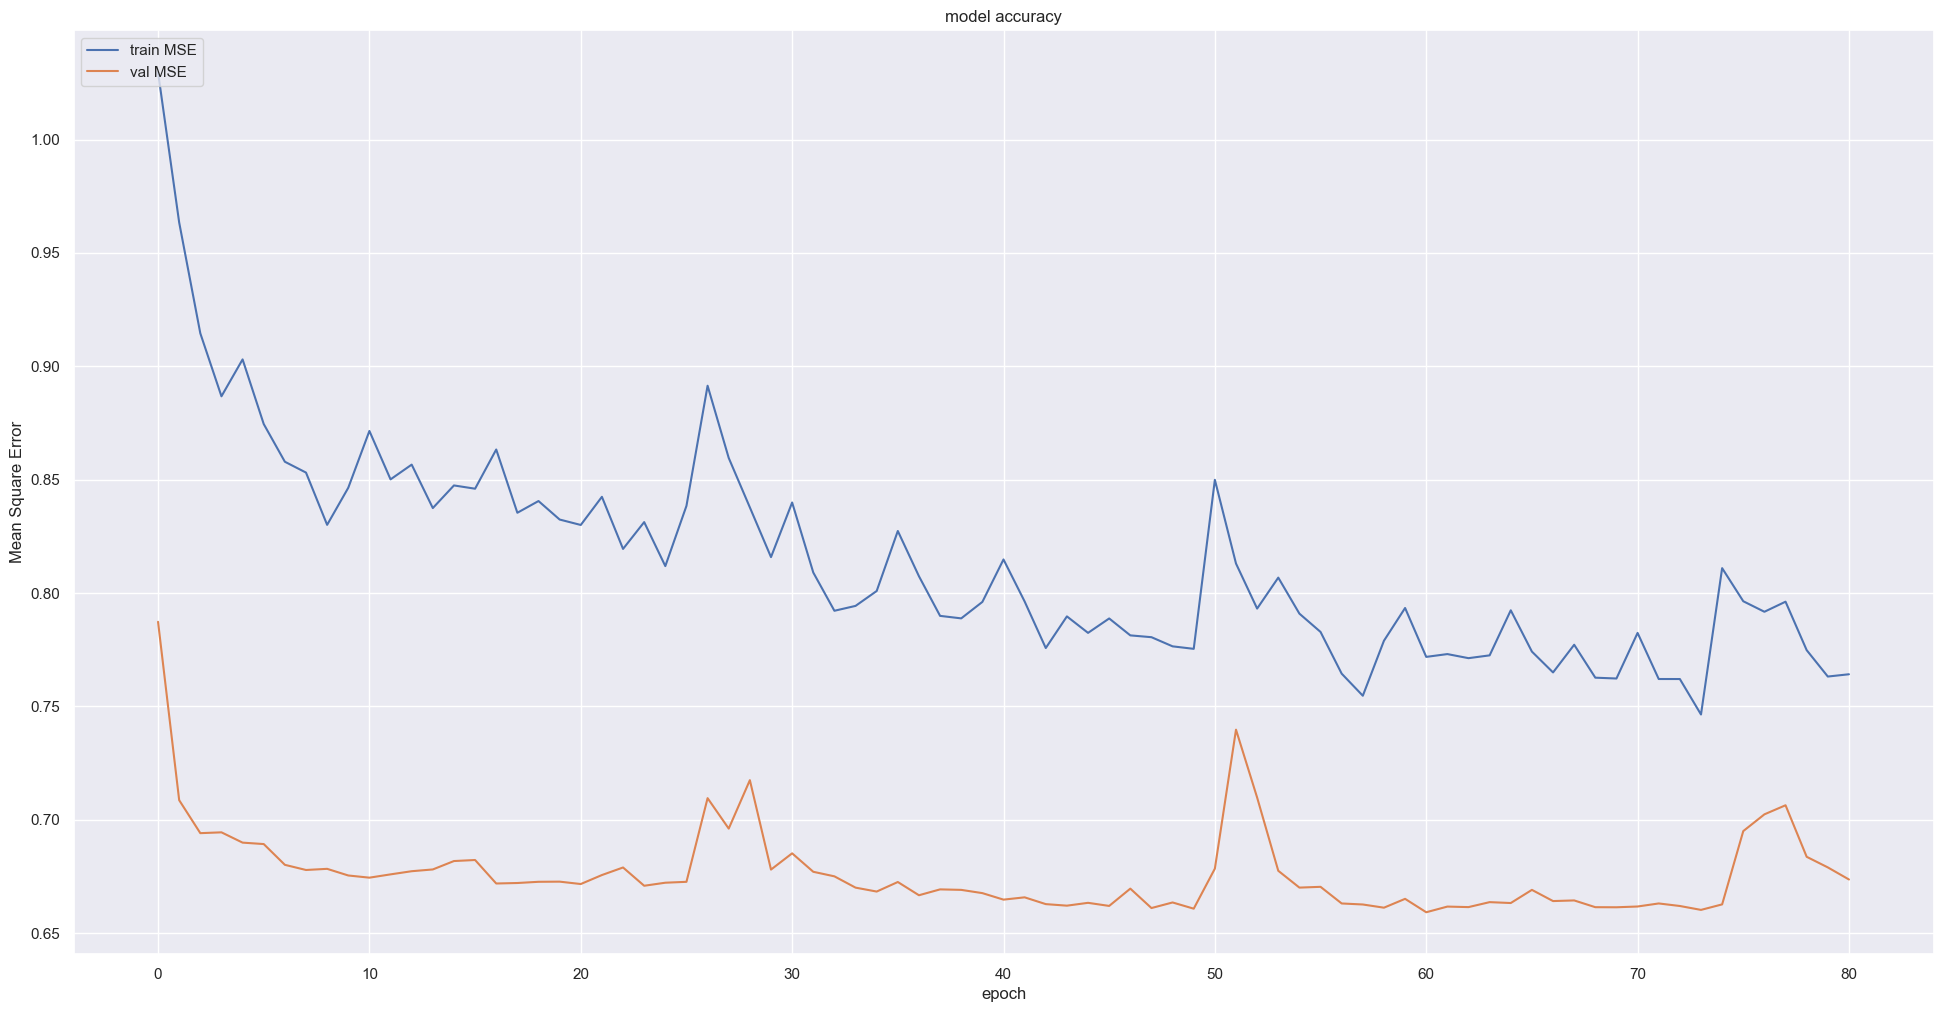

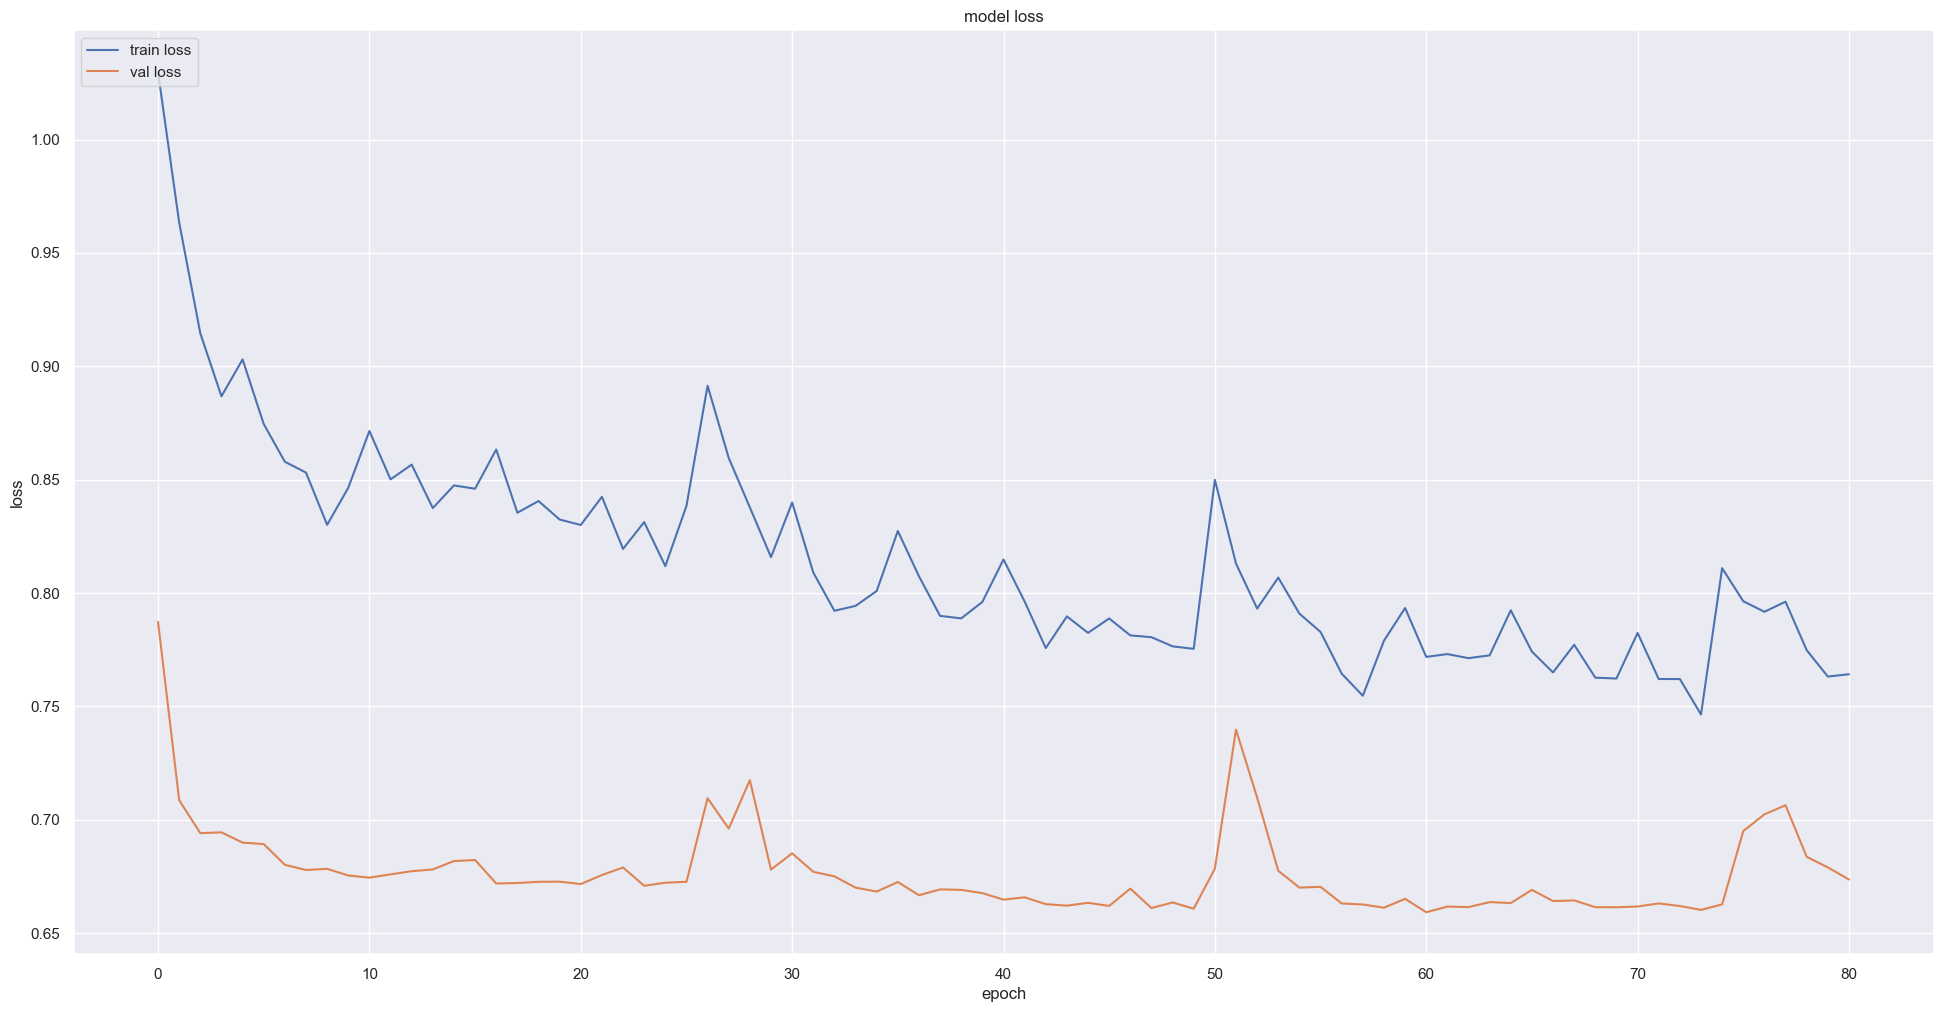

In [39]:
# plot Mean absolute error
loss_plot(History)

In [40]:
x_test[-5:]

array([[[0.48511781, 0.49796913],
        [0.50140424, 0.50365556],
        [0.50320811, 0.51096669],
        [0.49485908, 0.50609261],
        [0.50993318, 0.50284322],
        [0.49545213, 0.5077173 ],
        [0.49640541, 0.50852965],
        [0.50472841, 0.50446791],
        [0.48733408, 0.51665313],
        [0.48795231, 0.49553209],
        [0.49156084, 0.509342  ],
        [0.50385251, 0.50852965],
        [0.50496008, 0.50446791],
        [0.49130276, 0.50609261],
        [0.48983363, 0.5247766 ],
        [0.50668756, 0.49309504],
        [0.51464998, 0.509342  ],
        [0.50194582, 0.50609261],
        [0.49993462, 0.50284322],
        [0.49522035, 0.50609261],
        [0.52874625, 0.51990252],
        [0.50856817, 0.48497157],
        [0.48143329, 0.49715678],
        [0.49179191, 0.50852965],
        [0.49993583, 0.50609261],
        [0.50885149, 0.51015435],
        [0.50949705, 0.5077173 ],
        [0.49990962, 0.50446791],
        [0.50483208, 0.51096669],
        [0.503

241/241 [==============================] - 2s 5ms/step
Mean Square Error: 0.62
Mean Absolute Error: 0.26
Root Mean Square Error: 0.79
R-Square: 0.29




(-0.4, 0.4)

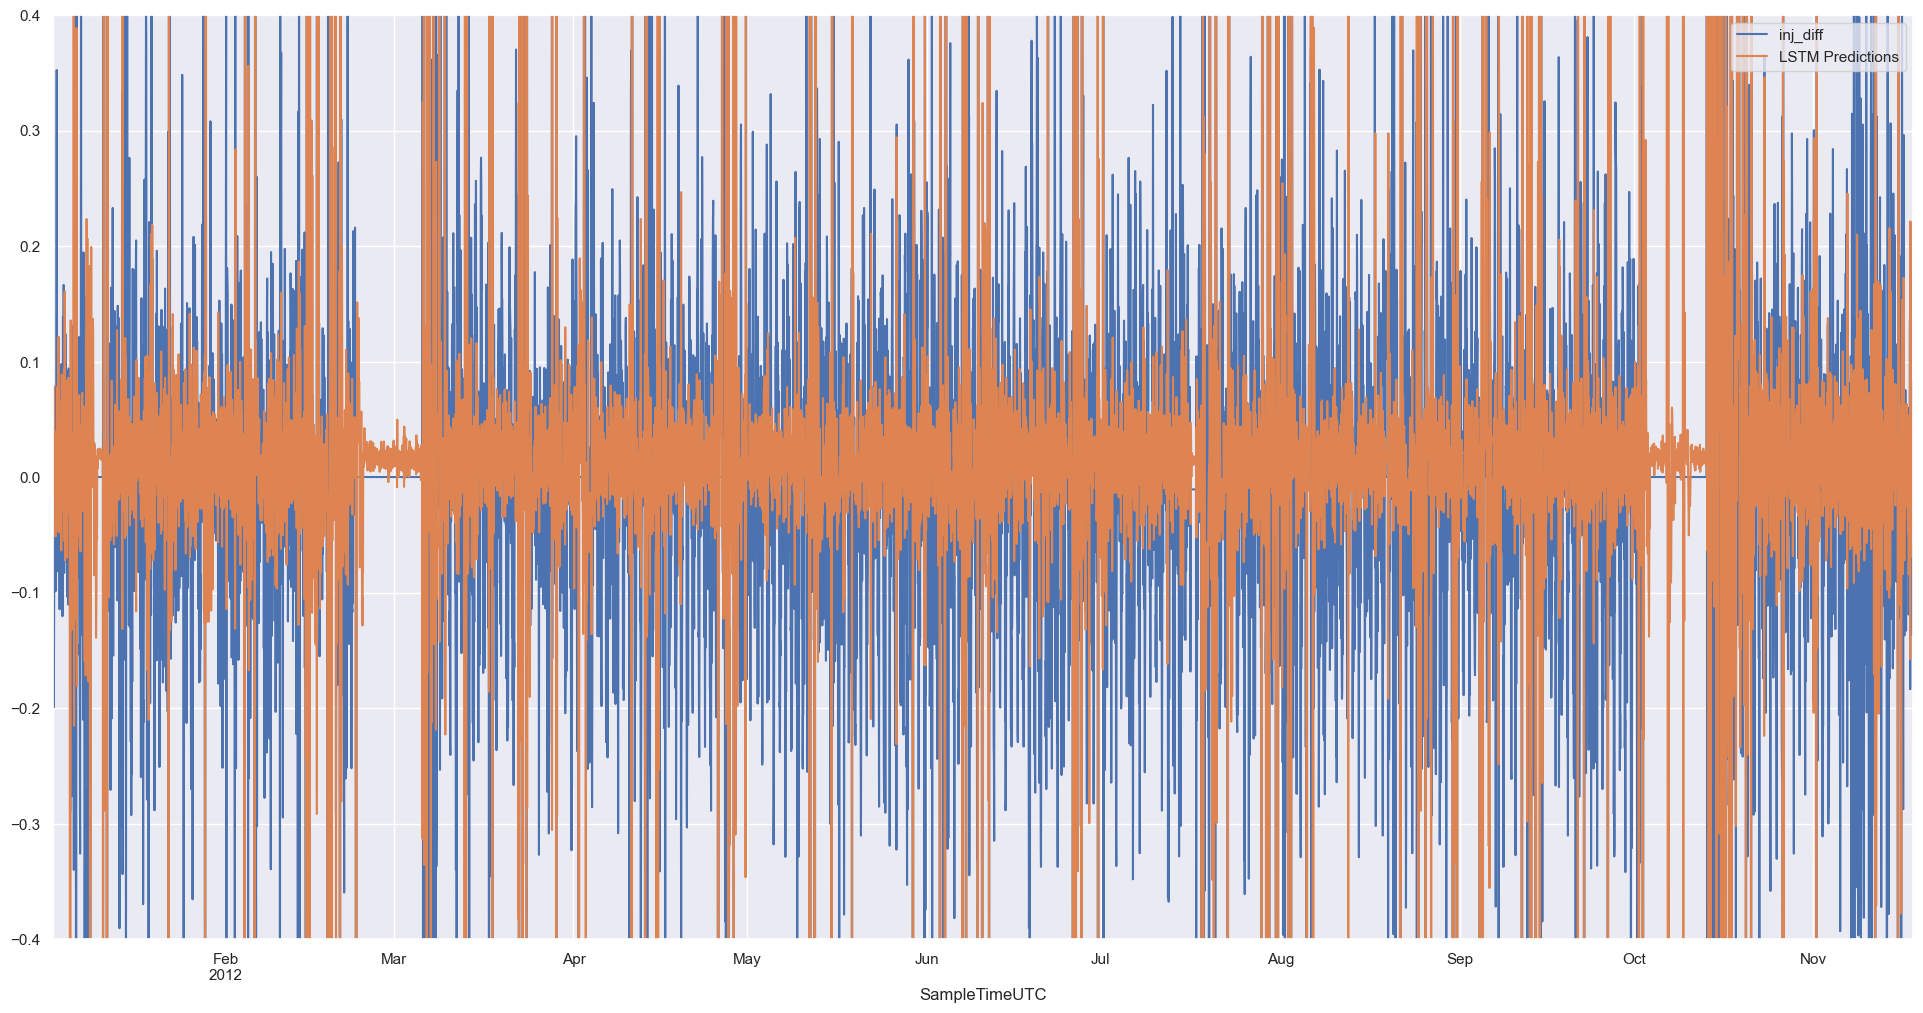

In [41]:
# make predictions and transform
#test_pred = scaler.inverse_transform(model.predict(x_test))
test_pred = model.predict(x_test)

pred_test = test[(n_steps_in-1):].copy()
pred_test["LSTM Predictions"] = test_pred
pred_test = pred_test[["inj_diff", "LSTM Predictions"]]

# evaluate predictions accuracy
evaluate_prediction(pred_test["LSTM Predictions"], pred_test["inj_diff"])

pred_test.plot()
plt.ylim([-0.4, 0.4])

In [42]:
pred_test

,inj_diff,LSTM Predictions
SampleTimeUTC,,
2012-01-02 05:00:00,-0.082985,0.059027
2012-01-02 06:00:00,0.017317,-0.017743
2012-01-02 07:00:00,-0.199262,0.078796
2012-01-02 08:00:00,-0.119444,0.046761
2012-01-02 09:00:00,-0.073265,0.014625
...,...,...
2012-11-18 03:00:00,-0.031250,0.023803
2012-11-18 04:00:00,-0.091320,0.022706
2012-11-18 05:00:00,-0.137501,-0.010066


### Deploy on Blind Data set

In [43]:
base_filename = 'illinois_basing_test_04112023'
csvs_sht = os.path.join(dir_name, base_filename + "." + filename_suffix)
#df.to_csv(csvs_sht, index = True, header = True)
print ("File to be loaded:", csvs_sht)

File to be loaded: C:\Users\DELL\Documents\GitHub\munishkumar-gh.github.io\Hackathon_2023\1_RAW_Data\illinois_basing_test_04112023.csv


In [44]:
skiprows = 0
#Means read in the ',' as thousand seperator. Also drops all columns which are unnamed.
df_blind = pd.read_csv(csvs_sht, thousands=',', skiprows = skiprows)
#df_blind.columns = df.columns.str.replace('\xa0', '')
df_blind["inj_diff"] = 0
df_blind.ends()

,SampleTimeUTC,Avg_PLT_CO2VentRate_TPH,Avg_CCS1_WHCO2InjPs_psi,Avg_CCS1_WHCO2InjTp_F,Avg_CCS1_ANPs_psi,Avg_CCS1_DH6325Ps_psi,Avg_CCS1_DH6325Tp_F,Avg_VW1_WBTbgPs_psi,Avg_VW1_WBTbgTp_F,Avg_VW1_ANPs_psi,...,Avg_VW1_Z04D6837Tp_F,Avg_VW1_Z03D6945Ps_psi,Avg_VW1_Z03D6945Tp_F,Avg_VW1_Z02D6982Ps_psi,Avg_VW1_Z02D6982Tp_F,Avg_VW1_Z01D7061Ps_psi,Avg_VW1_Z01D7061Tp_F,Avg_VW1_Z0910D5482Ps_psi,Avg_VW1_Z0910D5482Tp_F,inj_diff
0,11/18/2012 8:00,0.825000,1406.469561,95.529213,522.013451,3383.554036,129.535322,2329.030835,104.912923,0.100585,...,123.950680,NaN,NaN,3323.462998,123.443262,3320.276693,122.462348,2641.618345,110.552962,0
1,11/18/2012 9:00,0.641667,1406.399989,95.191933,510.494516,3385.778632,129.518488,2329.015361,104.909203,0.100585,...,123.953320,NaN,NaN,3323.513243,123.453597,3320.269031,122.457593,2641.630886,110.550592,0
2,11/18/2012 10:00,0.633333,1406.588710,95.546059,510.899432,3383.531185,129.466555,2329.055794,104.911063,NaN,...,123.950020,NaN,NaN,3323.566427,123.445062,3320.298985,122.453574,2641.633761,110.543437,0
3,11/18/2012 11:00,0.633333,1407.000806,95.382363,511.896438,3384.563845,129.481727,2329.133431,104.911993,NaN,...,123.955959,NaN,NaN,3323.579193,123.442497,3320.306563,122.458973,2641.664410,110.546602,0
4,11/18/2012 12:00,0.458333,1406.682945,95.643837,510.982277,3385.062998,129.459261,2329.147909,104.890602,NaN,...,123.952660,NaN,NaN,3323.572024,123.448467,3320.344305,122.463683,2641.688436,110.541832,0
196,11/26/2012 12:00,1.708333,1418.840352,96.514320,440.463678,3398.568276,129.185358,2327.606797,104.914033,2.644836,...,124.241981,0.0,0.0,3321.337750,123.516012,3321.700452,122.553698,2640.481917,110.566567,0
197,11/26/2012 13:00,1.708333,1418.537537,96.197548,432.052225,3399.234914,129.200211,2327.799504,104.898972,2.620117,...,124.245941,0.0,0.0,3321.381618,123.511662,3321.754409,122.555723,2640.675960,110.560132,0
198,11/26/2012 14:00,1.716667,1418.984295,96.460487,513.740069,3400.701626,129.224400,2327.909432,104.900832,2.648498,...,124.251221,0.0,0.0,3321.374638,123.516882,3321.721102,122.550998,2640.760974,110.560132,0
199,11/26/2012 15:00,1.566667,1419.207662,96.425332,621.174498,3403.130627,129.259234,2327.912443,104.905483,2.674133,...,124.245941,0.0,0.0,3321.392446,123.513387,3321.729205,122.554373,2640.762337,110.563312,0
200,11/26/2012 16:00,0.025000,1143.615576,89.688881,561.435533,3111.476807,128.116005,2327.892611,104.905483,2.670471,...,124.254520,0.0,0.0,3321.358042,123.512532,3321.724227,122.556398,2640.735295,110.562517,0


In [45]:
df_blind['SampleTimeUTC'] = pd.to_datetime(df_blind['SampleTimeUTC'])
df_blind = df_blind.set_index("SampleTimeUTC")
idx = pd.date_range(df_blind.index[0], df_blind.index[-1])

#df1 = df1.reindex(idx, fill_value=np.nan).dropna()
df_blind.index.name = "SampleTimeUTC"

df_blind = df_blind.asfreq('H')

#df1.index.freq = "H"
df_blind

,Avg_PLT_CO2VentRate_TPH,Avg_CCS1_WHCO2InjPs_psi,Avg_CCS1_WHCO2InjTp_F,Avg_CCS1_ANPs_psi,Avg_CCS1_DH6325Ps_psi,Avg_CCS1_DH6325Tp_F,Avg_VW1_WBTbgPs_psi,Avg_VW1_WBTbgTp_F,Avg_VW1_ANPs_psi,Avg_VW1_Z11D4917Ps_psi,...,Avg_VW1_Z04D6837Tp_F,Avg_VW1_Z03D6945Ps_psi,Avg_VW1_Z03D6945Tp_F,Avg_VW1_Z02D6982Ps_psi,Avg_VW1_Z02D6982Tp_F,Avg_VW1_Z01D7061Ps_psi,Avg_VW1_Z01D7061Tp_F,Avg_VW1_Z0910D5482Ps_psi,Avg_VW1_Z0910D5482Tp_F,inj_diff
SampleTimeUTC,,,,,,,,,,,,,,,,,,,,,
2012-11-18 08:00:00,0.825000,1406.469561,95.529213,522.013451,3383.554036,129.535322,2329.030835,104.912923,0.100585,2069.938165,...,123.950680,NaN,NaN,3323.462998,123.443262,3320.276693,122.462348,2641.618345,110.552962,0
2012-11-18 09:00:00,0.641667,1406.399989,95.191933,510.494516,3385.778632,129.518488,2329.015361,104.909203,0.100585,2069.942957,...,123.953320,NaN,NaN,3323.513243,123.453597,3320.269031,122.457593,2641.630886,110.550592,0
2012-11-18 10:00:00,0.633333,1406.588710,95.546059,510.899432,3383.531185,129.466555,2329.055794,104.911063,NaN,2069.882166,...,123.950020,NaN,NaN,3323.566427,123.445062,3320.298985,122.453574,2641.633761,110.543437,0
2012-11-18 11:00:00,0.633333,1407.000806,95.382363,511.896438,3384.563845,129.481727,2329.133431,104.911993,NaN,2069.932163,...,123.955959,NaN,NaN,3323.579193,123.442497,3320.306563,122.458973,2641.664410,110.546602,0
2012-11-18 12:00:00,0.458333,1406.682945,95.643837,510.982277,3385.062998,129.459261,2329.147909,104.890602,NaN,2069.892961,...,123.952660,NaN,NaN,3323.572024,123.448467,3320.344305,122.463683,2641.688436,110.541832,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-11-26 12:00:00,1.708333,1418.840352,96.514320,440.463678,3398.568276,129.185358,2327.606797,104.914033,2.644836,2069.778320,...,124.241981,0.0,0.0,3321.337750,123.516012,3321.700452,122.553698,2640.481917,110.566567,0
2012-11-26 13:00:00,1.708333,1418.537537,96.197548,432.052225,3399.234914,129.200211,2327.799504,104.898972,2.620117,2069.796224,...,124.245941,0.0,0.0,3321.381618,123.511662,3321.754409,122.555723,2640.675960,110.560132,0
2012-11-26 14:00:00,1.716667,1418.984295,96.460487,513.740069,3400.701626,129.224400,2327.909432,104.900832,2.648498,2069.795003,...,124.251221,0.0,0.0,3321.374638,123.516882,3321.721102,122.550998,2640.760974,110.560132,0


In [46]:
df_blind_new = df_blind[Feature]
df_blind_new["Delta_Avg_CCS1_WHCO2InjPs_psi"]=df_blind_new["Avg_CCS1_WHCO2InjPs_psi"].diff().fillna(0)
df_blind_new["Delta_Avg_PLT_CO2VentRate_TPH"]=df_blind_new["Avg_PLT_CO2VentRate_TPH"].diff().fillna(0)
df_blind_new.drop(['Avg_CCS1_WHCO2InjPs_psi', 'Avg_PLT_CO2VentRate_TPH'], axis=1, inplace=True)

data2 = df_blind_new.copy()
data2.ends()

,inj_diff,Delta_Avg_CCS1_WHCO2InjPs_psi,Delta_Avg_PLT_CO2VentRate_TPH
SampleTimeUTC,,,
2012-11-18 08:00:00,0,0.000000,0.000000
2012-11-18 09:00:00,0,-0.069572,-0.183333
2012-11-18 10:00:00,0,0.188721,-0.008333
2012-11-18 11:00:00,0,0.412096,0.000000
2012-11-18 12:00:00,0,-0.317861,-0.175000
2012-11-26 12:00:00,0,0.049621,-0.083333
2012-11-26 13:00:00,0,-0.302815,0.000000
2012-11-26 14:00:00,0,0.446758,0.008333
2012-11-26 15:00:00,0,0.223367,-0.150000


In [47]:
# Get last n rows of df_train
last_n_rows = df_clean.tail(n_steps_in)

# Concatenate last_n_rows with df_test
data2 = pd.concat([last_n_rows, data2], axis=0)

In [48]:
data2.shape

(231, 3)

In [49]:
df_clean2 = df_clean.copy()

In [50]:
df_clean2['LSTM Predictions'] = pred_test['LSTM Predictions']

In [51]:
df_clean2

,inj_diff,Delta_Avg_CCS1_WHCO2InjPs_psi,Delta_Avg_PLT_CO2VentRate_TPH,LSTM Predictions
SampleTimeUTC,,,,
2009-10-01 00:00:00,0.000000,0.000000,0.000000,NaN
2009-10-01 01:00:00,0.000000,-0.505859,0.000000,NaN
2009-10-01 02:00:00,0.000000,-0.059245,0.000000,NaN
2009-10-01 03:00:00,0.000000,-0.059245,0.000000,NaN
2009-10-01 04:00:00,0.000000,0.086589,0.000000,NaN
...,...,...,...,...
2012-11-18 03:00:00,-0.031250,0.590679,0.008333,0.023803
2012-11-18 04:00:00,-0.091320,-0.665153,0.050000,0.022706
2012-11-18 05:00:00,-0.137501,-0.387288,0.050000,-0.010066


In [52]:
train2 = data2
test2 = data2

x_train2, y_train2 = train2.drop("inj_diff", axis=1).values, train2["inj_diff"].values
x_test2, y_test2 = test2.drop("inj_diff", axis=1).values, test2["inj_diff"].values

train_data2, test_data2 = reshape_data(x_train2, y_train2, x_test2, y_test2)

# covert into input/output
X2, y2 = split_sequences(train_data2, n_steps_in, n_steps_out)
x_test2, y_test2 = split_sequences(test_data2, n_steps_in, n_steps_out)
print ("X2.shape" , X2.shape) 
print ("y2.shape" , y2.shape)

n_features = X2.shape[2]

train dataset_stacked.shape (231, 3)
test dataset_stacked.shape (231, 3)
X2.shape (202, 30, 2)
y2.shape (202, 1)


In [53]:
x_test2.shape
#print(x_test2[-5:])

(202, 30, 2)

7/7 [==============================] - 0s 5ms/step


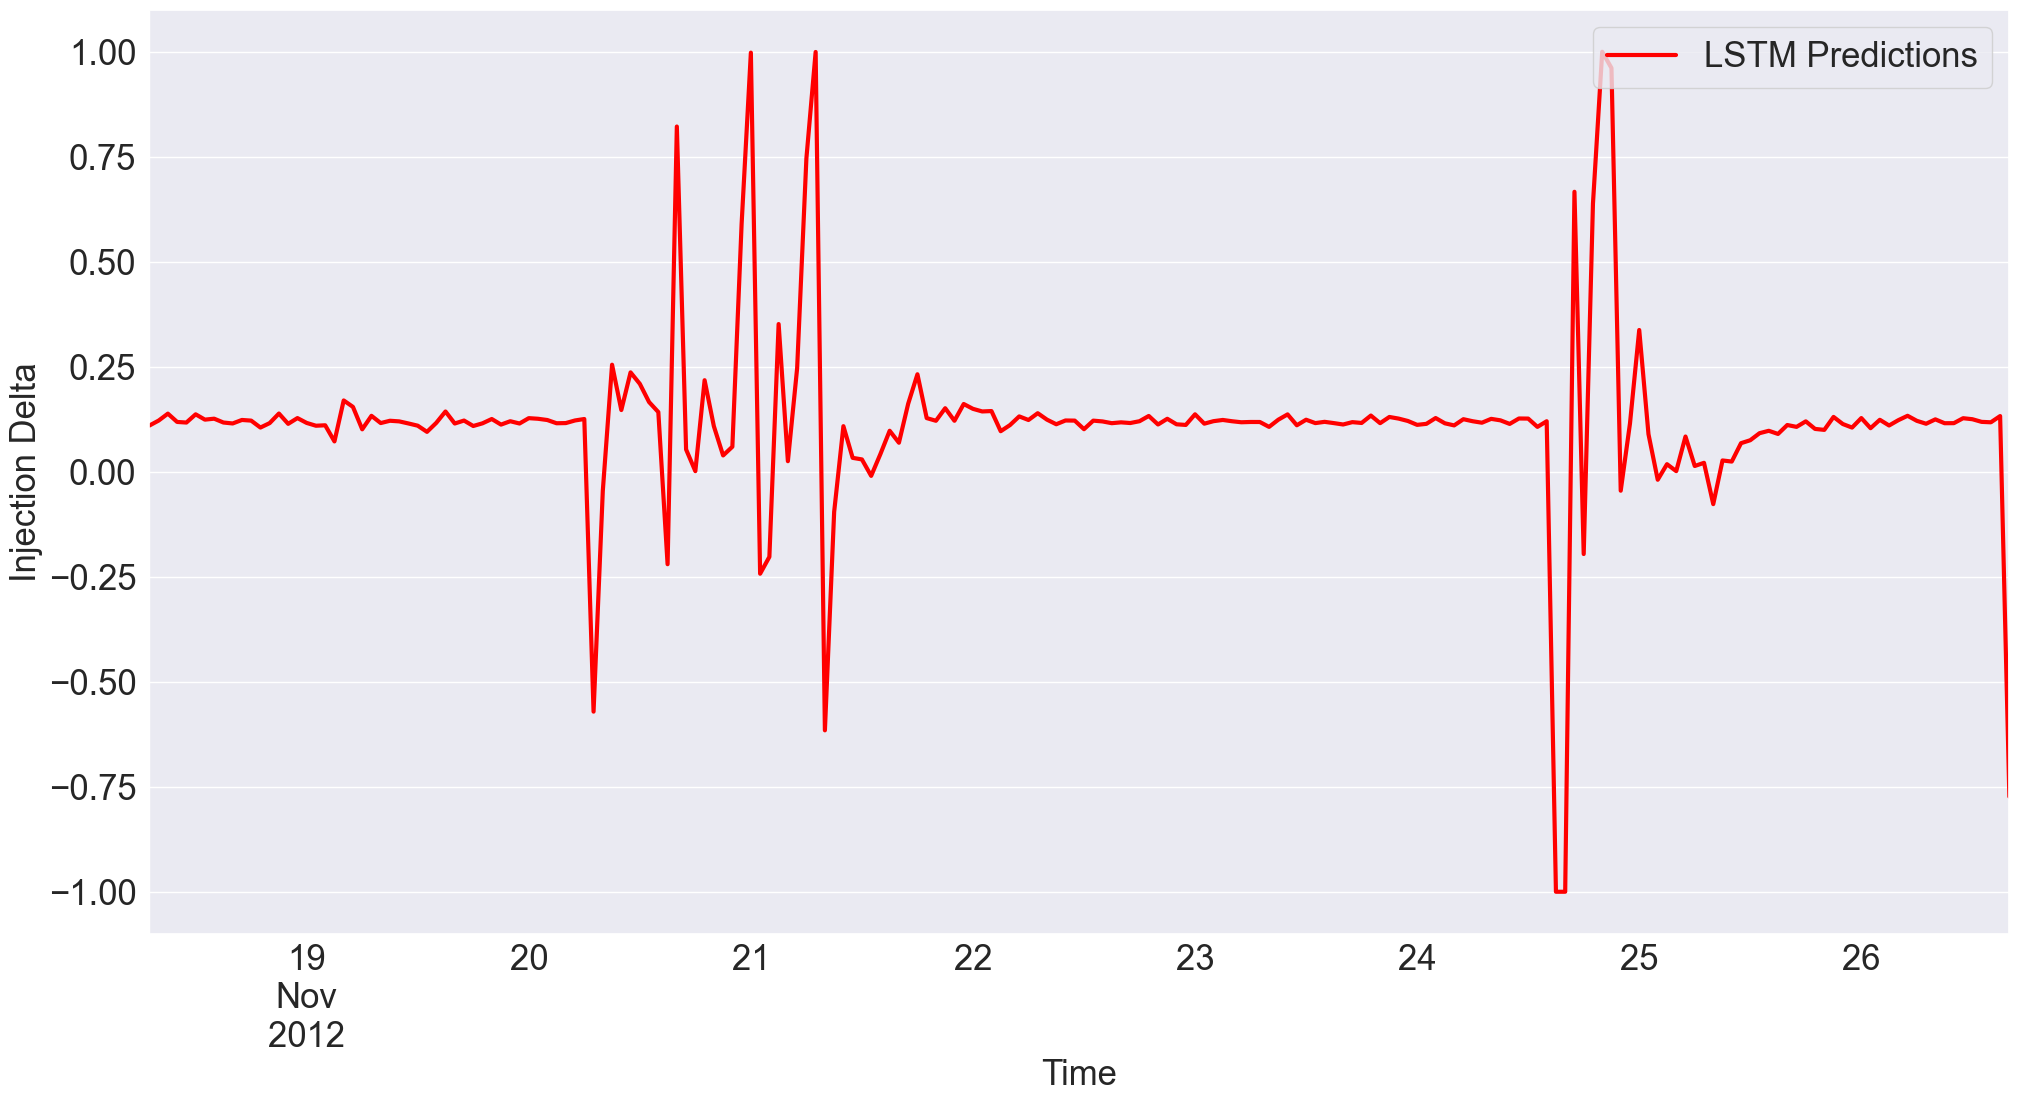

In [54]:
# make predictions and transform
#test_pred2 = scaler.inverse_transform(model.predict(x_test2))
test_pred2 = model.predict(x_test2)

pred_test2 = test2[(n_steps_in-1):].copy()
pred_test2["LSTM Predictions"] = test_pred2
pred_test2 = pred_test2[["inj_diff", "LSTM Predictions"]]

plot_pred_test2 = pred_test2[["LSTM Predictions"]]

plot_pred_test2.plot(linewidth = 3, fontsize = fontsize, color='red')
plt.xlabel("Time", size = fontsize)
plt.ylabel("Injection Delta", size = fontsize)
plt.legend(fontsize=fontsize, loc ="upper right")

In [55]:
data2['inj_diff'] = pred_test2["LSTM Predictions"]

### We have determined a prediction for the delta injection value

In [56]:
data2 = data2.drop(data2.index[:n_steps_in])

data2

,inj_diff,Delta_Avg_CCS1_WHCO2InjPs_psi,Delta_Avg_PLT_CO2VentRate_TPH
SampleTimeUTC,,,
2012-11-18 08:00:00,0.121881,0.000000,0.000000
2012-11-18 09:00:00,0.138406,-0.069572,-0.183333
2012-11-18 10:00:00,0.118647,0.188721,-0.008333
2012-11-18 11:00:00,0.117207,0.412096,0.000000
2012-11-18 12:00:00,0.136806,-0.317861,-0.175000
...,...,...,...
2012-11-26 12:00:00,0.125127,0.049621,-0.083333
2012-11-26 13:00:00,0.118820,-0.302815,0.000000
2012-11-26 14:00:00,0.117804,0.446758,0.008333


In [57]:
#df_clean = df_clean.rename(columns={'inj_diff': 'inj_diff'})
df_clean

,inj_diff,Delta_Avg_CCS1_WHCO2InjPs_psi,Delta_Avg_PLT_CO2VentRate_TPH
SampleTimeUTC,,,
2009-10-01 00:00:00,0.000000,0.000000,0.000000
2009-10-01 01:00:00,0.000000,-0.505859,0.000000
2009-10-01 02:00:00,0.000000,-0.059245,0.000000
2009-10-01 03:00:00,0.000000,-0.059245,0.000000
2009-10-01 04:00:00,0.000000,0.086589,0.000000
...,...,...,...
2012-11-18 03:00:00,-0.031250,0.590679,0.008333
2012-11-18 04:00:00,-0.091320,-0.665153,0.050000
2012-11-18 05:00:00,-0.137501,-0.387288,0.050000


In [58]:
dfmer = pd.concat([df_clean, data2], axis=0)

In [59]:
print(df_clean.shape)
print(data2.shape)
print(dfmer.shape)

(27464, 3)
(201, 3)
(27665, 3)


In [60]:
dfmer.index

DatetimeIndex(['2009-10-01 00:00:00', '2009-10-01 01:00:00',
               '2009-10-01 02:00:00', '2009-10-01 03:00:00',
               '2009-10-01 04:00:00', '2009-10-01 05:00:00',
               '2009-10-01 06:00:00', '2009-10-01 07:00:00',
               '2009-10-01 08:00:00', '2009-10-01 09:00:00',
               ...
               '2012-11-26 07:00:00', '2012-11-26 08:00:00',
               '2012-11-26 09:00:00', '2012-11-26 10:00:00',
               '2012-11-26 11:00:00', '2012-11-26 12:00:00',
               '2012-11-26 13:00:00', '2012-11-26 14:00:00',
               '2012-11-26 15:00:00', '2012-11-26 16:00:00'],
              dtype='datetime64[ns]', name='SampleTimeUTC', length=27665, freq='H')

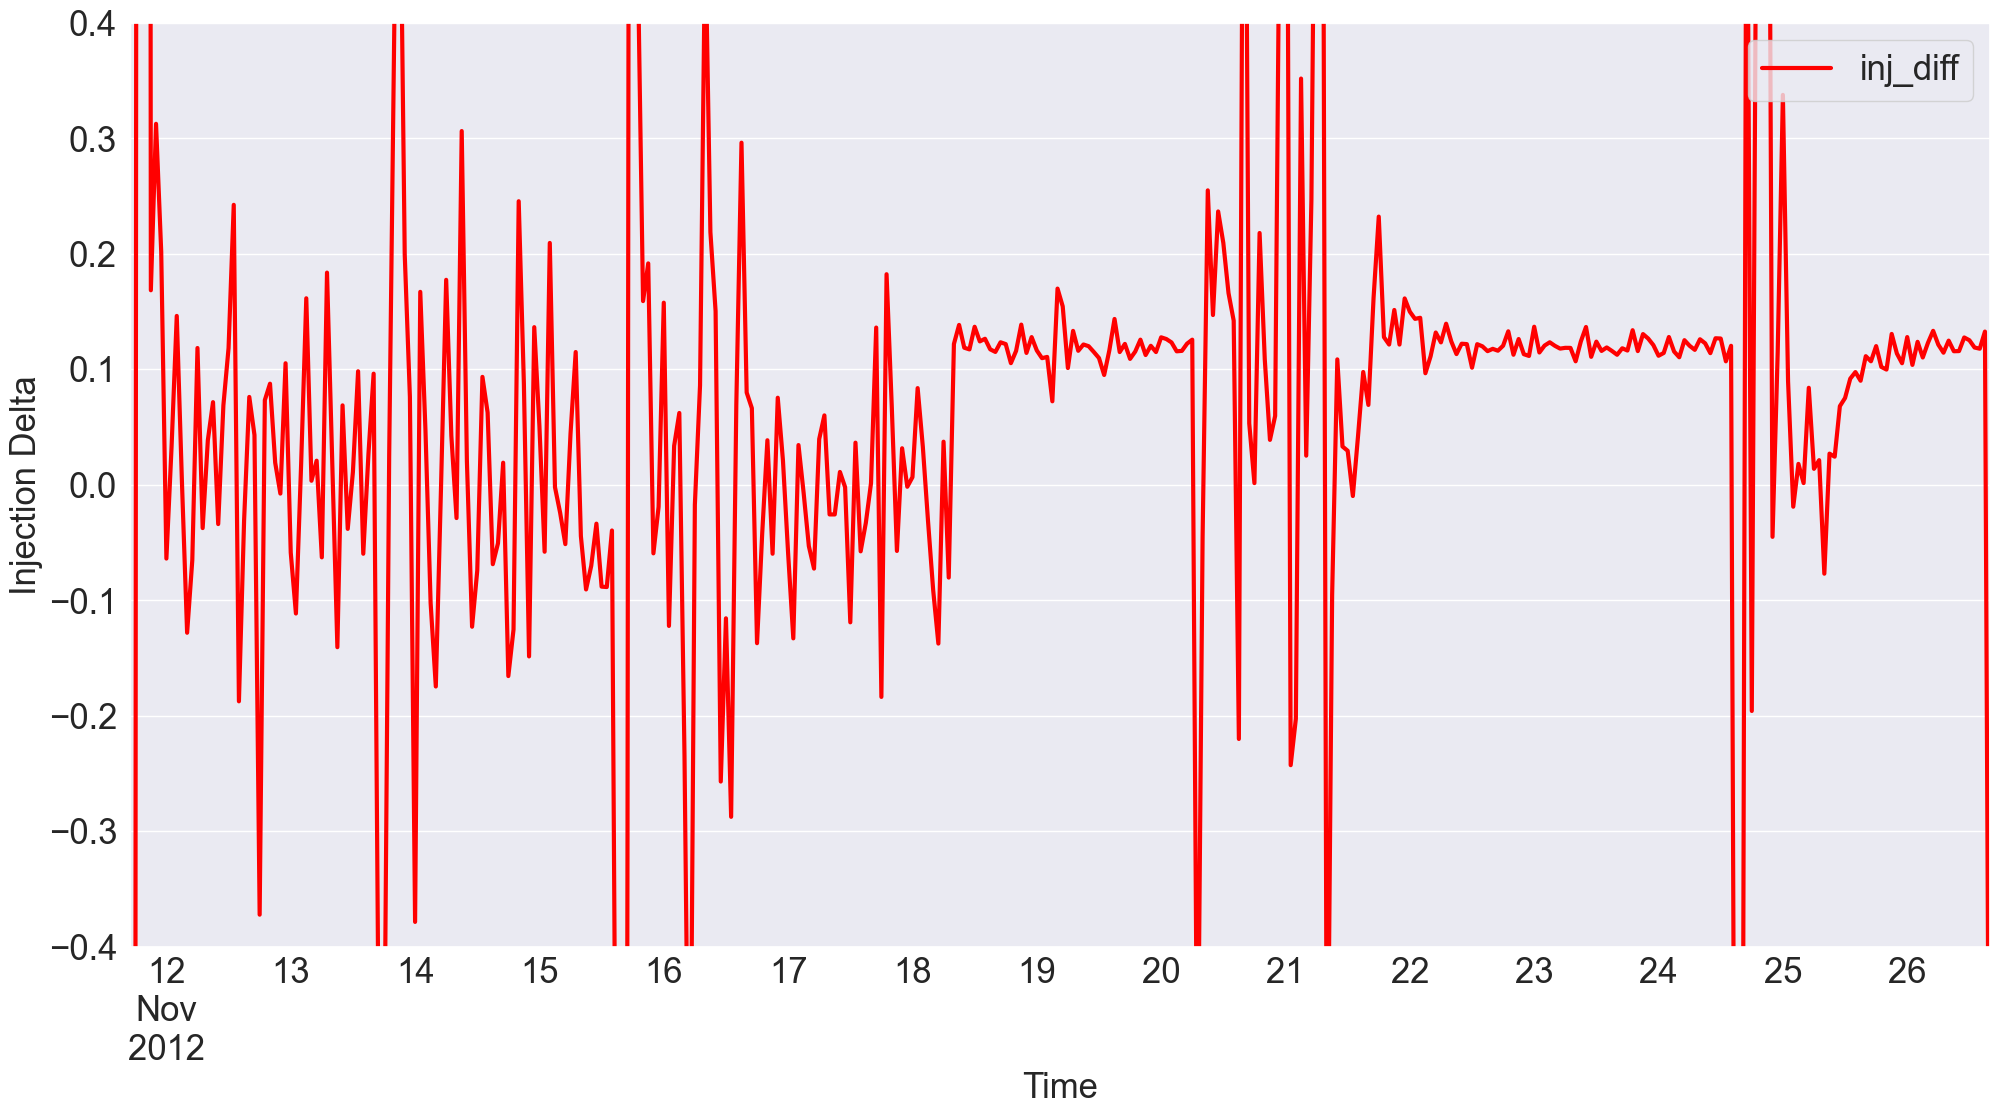

In [61]:
last_6_months = dfmer.tail(12*30)
last_6_months['inj_diff'].plot(linewidth=3, fontsize=fontsize, color='red')
plt.xlabel("Time", size=fontsize)
plt.ylabel("Injection Delta", size=fontsize)
plt.legend(fontsize=fontsize, loc="upper right")
# Set the y-axis limit
plt.ylim([-0.4, 0.4])

# Display the plot
plt.show()

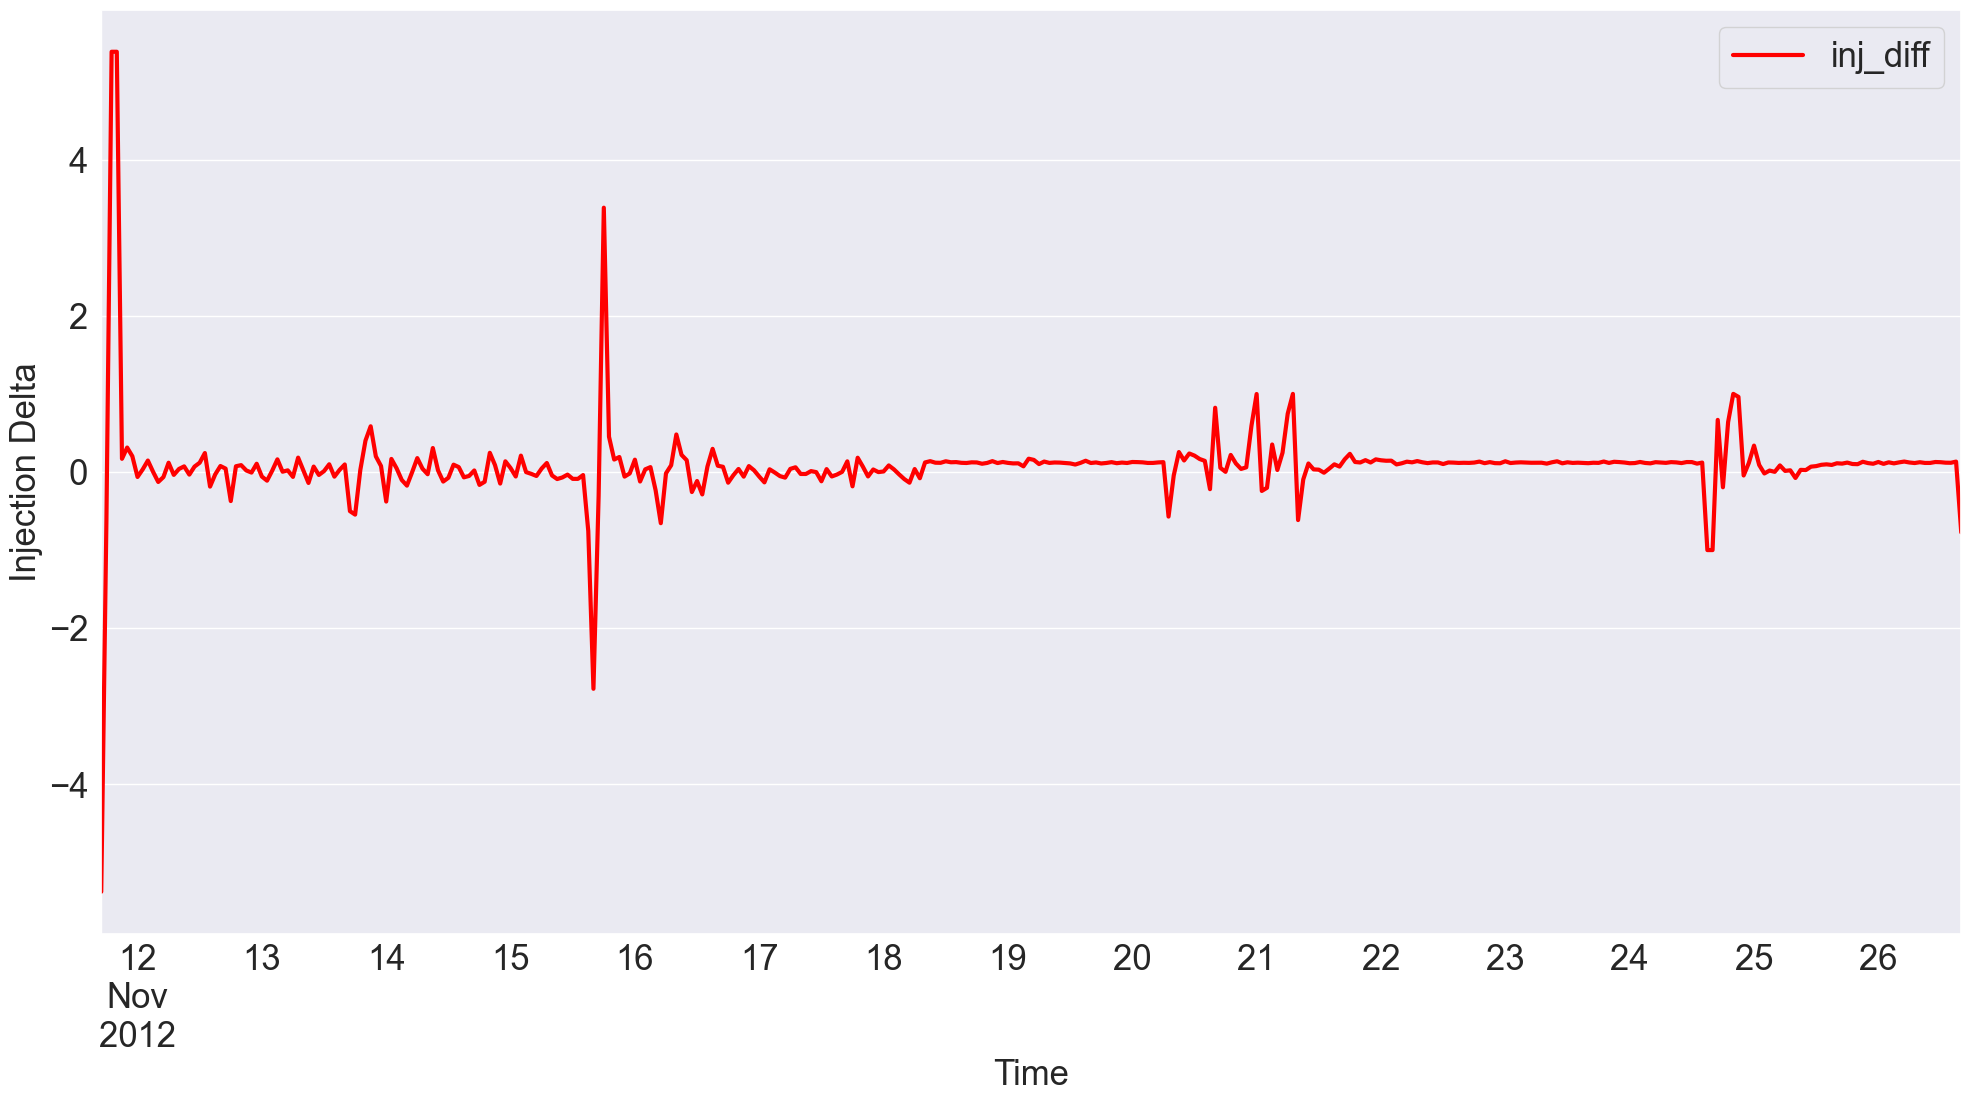

In [62]:
last_6_months = dfmer.tail(12*30)
last_6_months['inj_diff'].plot(linewidth=3, fontsize=fontsize, color='red')
plt.xlabel("Time", size=fontsize)
plt.ylabel("Injection Delta", size=fontsize)
plt.legend(fontsize=fontsize, loc="upper right")
# Set the y-axis limit
#plt.ylim([-0.4, 0.4])

# Display the plot
plt.show()

In [63]:
last_6_months = dfmer.tail(12*30)
last_6_months['Avg_PLT_CO2VentRate_TPH'].plot(linewidth=3, fontsize=fontsize, color='red')
plt.xlabel("Time", size=fontsize)
plt.ylabel("Injection Delta", size=fontsize)
plt.legend(fontsize=fontsize, loc="upper right")

KeyError: 'Avg_PLT_CO2VentRate_TPH'

### Conclusion

In [ ]:
base_filename = 'Final_output'
csvs_sht = os.path.join(dir_name, base_filename + "." + filename_suffix)
plot_pred_test2.to_csv(csvs_sht, index = True, header = True)
print ("File exported:", base_filename + "." + filename_suffix)

In [ ]:
count = 'Completed Process'
elapsed = (time.time() - start)
print ("%s in %s seconds" % (count,elapsed))

Submission

Once the machine learning model is developed and evaluated, contestants submit the ML code to an SPEMLChallenge@gmail.com.  The results are submitted to the XEEK.org platform for preliminary scoring.   